In [ ]:
pip install -r requirements.txt

In [6]:
"""Importing all functions needed for this project."""
import pandas as pd
import numpy as np
import re
import ast

from dateutil.parser import parse

import chardet

import matplotlib.pyplot as plt
import seaborn as sns

import mysql.connector

from sqlalchemy import (create_engine, text, Column, Integer, String, Float, 
Boolean, BigInteger, DateTime, ForeignKey, PrimaryKeyConstraint)
from sqlalchemy.schema import CreateTable
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

from db_config import username, password, host, port, database

from functions_all import (detect_encoding, split_and_get_first, convert_string_to_list, 
  standardize_date_format, df_to_lowercase, analyze_categorical_column, extract_authors, 
  remove_brackets_content, most_common_lang, impute_missing_values, winsorize, 
  outliers_numerical_cols, distribution_numerical_cols, outlier_cols, explode_column_to_table, 
  serialize_id, factorize_id)

In [7]:
"""These functions do not work properly if they are imported from a different script. 
They still work but do not create Primary and Foreign keys for the tables."""
def mysql_class_from_df_pk(
    df: pd.DataFrame, tablename: str, pk_key: str = "bookId"
) -> type:
    """Create a SQLAlchemy class with a primary key for DataFrame.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - tablename (str): Desired table name for the SQLAlchemy class.
    - pk_key (str, optional): Name of the primary key column. Default is "bookId".

    Returns:
    - type: SQLAlchemy ORM class.
    """

    type_mapping = {
        "int64": BigInteger,
        "Int64": BigInteger,
        "float64": Float,
        "object": String(300),
        "string": String(300),
        "bool": Boolean,
        "boolean": Boolean,
        "datetime64[ns]": DateTime,
    }

    attrs = {
        "__tablename__": tablename,
        "__table_args__": {"extend_existing": True},
    }

    for col, dtype in df.dtypes.items():
        if col == pk_key:
            attrs[col] = Column(
                type_mapping[str(dtype)], primary_key=True, autoincrement=True
            )
        else:
            attrs[col] = Column(type_mapping[str(dtype)])

    return type(tablename, (Base,), attrs)

def mysql_class_from_df_fk(
    df: pd.DataFrame, table_name: str) -> type:
    """Dynamically create an ORM class with a foreign key based on a given pandas DataFrame.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - table_name (str): Desired table name for the SQLAlchemy class.
    - secondary_pk_col (str): The secondary column name for the composite primary key.

    Returns:
    - type: SQLAlchemy ORM class.
    """

    type_mapping = {
        "int64": BigInteger,
        "Int64": BigInteger,
        "float64": Float,
        "object": String(300),
        "string": String(300),
        "bool": Boolean,
        "boolean": Boolean,
        "datetime64[ns]": DateTime,
    }

    attributes = {
        "__tablename__": table_name,
        "__table_args__": {
            "extend_existing": True
        },
        "bookId": Column(
            BigInteger, ForeignKey("books.bookId")
        ),
    }

    primary_key_name = table_name + "Id"
    attributes[primary_key_name] = Column(Integer, primary_key=True, autoincrement=True)

    for column, dtype in df.dtypes.items():
        if column not in [
            "bookId",
            primary_key_name,
        ]:
            attributes[column] = Column(type_mapping[str(dtype)])



    new_class = type(table_name, (Base,), attributes)
    return new_class


# Identifying file encoding
Looking for encoding type fails. These blocks are commented out because they prevent running the whole script because they break.

In [8]:
"""
file_path = "books_1.Best_Books_Ever.csv"
encoding = detect_encoding(file_path)
print(f"Detected encoding: {encoding}")
"""

'\nfile_path = "books_1.Best_Books_Ever.csv"\nencoding = detect_encoding(file_path)\nprint(f"Detected encoding: {encoding}")\n'

In [9]:
"""data = pd.read_csv("books_1.Best_Books_Ever.csv", encoding=encoding)
df = pd.DataFrame(data)"""

'data = pd.read_csv("books_1.Best_Books_Ever.csv", encoding=encoding)\ndf = pd.DataFrame(data)'

# Loading, EDA and data cleaning

In [85]:
"""Import and load the data into a dataframe with preferred encoding."""
data = pd.read_csv("books_1.Best_Books_Ever.csv", encoding='utf-8')
df = pd.DataFrame(data)

In [86]:
df.head(5)

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",...,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,2993816,30516,5.09
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",...,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,7.38
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,9999999999999,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",...,07/11/60,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...,2269402,23328,NaN
3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,9999999999999,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",...,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",https://i.gr-assets.com/images/S/compressed.ph...,1983116,20452,NaN
4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",...,10/05/05,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...,1459448,14874,2.1


In [87]:
df = df_to_lowercase(df)
df = df.drop_duplicates()

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52428 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            52428 non-null  object 
 1   title             52428 non-null  object 
 2   series            23445 non-null  object 
 3   author            52428 non-null  object 
 4   rating            52428 non-null  float64
 5   description       51092 non-null  object 
 6   language          48627 non-null  object 
 7   isbn              52428 non-null  object 
 8   genres            52428 non-null  object 
 9   characters        52428 non-null  object 
 10  bookFormat        50955 non-null  object 
 11  edition           4949 non-null   object 
 12  pages             50085 non-null  object 
 13  publisher         48736 non-null  object 
 14  publishDate       51549 non-null  object 
 15  firstPublishDate  31125 non-null  object 
 16  awards            52428 non-null  object

In [89]:
"""Mapping for column names and types."""
columns_dict = {
                'title': 'string',
                'series': 'string',
                'author': 'string',
                'description': 'string',
                'language': 'string',
                'bookFormat': 'string',
                'edition': 'string',
                'publisher': 'string',
                'coverImg': 'string',
                'language': 'string',
                'bookFormat': 'string',
                'edition': 'string',
                'publisher': 'string',
                'characters': 'string',
                'awards': 'string',
                'author': 'string',
                'setting': 'string',
                'genres': 'string',
                'coverImg': 'string'
                }

for column, dtype in columns_dict.items():
    try:
        df[column] = df[column].astype(dtype)
    except ValueError:
        print(f'Column {column} dtype change failed!')
        
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['pages'] = pd.to_numeric(df['pages'], errors='coerce').astype('Int64')

In [90]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,52428.0,4.021865,0.367116,0.0,3.82,4.03,4.23,5.0
pages,50062.0,328.706664,252.264913,0.0,210.0,304.0,392.0,14777.0
numRatings,52428.0,17892.59844,103993.201959,0.0,341.0,2309.5,9389.0,7048471.0
likedPercent,51807.0,92.231938,5.988683,0.0,90.0,94.0,96.0,100.0
bbeScore,52428.0,1985.832475,35169.854432,0.0,84.0,97.0,187.0,2993816.0
bbeVotes,52428.0,22.549535,369.333934,-4.0,1.0,1.0,2.0,30516.0
price,38072.0,9.657951,24.305323,0.84,3.24,5.2,8.8525,898.64


In [91]:
"""Because bookId is not a good unique identifier I'm looking into combination of title, author, 
descrition and publishDate for a way to identify duplicates."""
"""Check for duplicates based on the 'title', 'author', and 'description' columns."""
potential_duplicates = df[df.duplicated(subset=['title', 'author', 'description'], keep=False)].sort_values(by=['title', 'author'])
potential_duplicates[['title', 'author', 'description', 'price']].head(10)

"""Dropping duplicates, sort lets us keep the duplicate with higher price."""
df = df.sort_values(by='price', ascending=False)
df = df.drop_duplicates(subset=['title', 'author', 'description'], keep='first')

In [92]:
potential_duplicates = df[df.duplicated(subset=['title', 'author', 'isbn'], keep=False)].sort_values(by=['isbn', 'title'])
potential_duplicates[['title', 'author', 'isbn']].head(10)

,title,author,isbn
25628,wolf hall,hilary mantel (goodreads author),9780312429980
1296,wolf hall,hilary mantel (goodreads author),9780312429980
23159,edgedancer,brandon sanderson (goodreads author),9781250166548
27486,edgedancer,brandon sanderson (goodreads author),9781250166548
23519,john lars zwerenz the complete anthology,john lars zwerenz,9999999999999
25539,john lars zwerenz the complete anthology,john lars zwerenz,9999999999999


In [93]:
df = df.drop_duplicates(subset=['title', 'author', 'isbn'], keep='first')

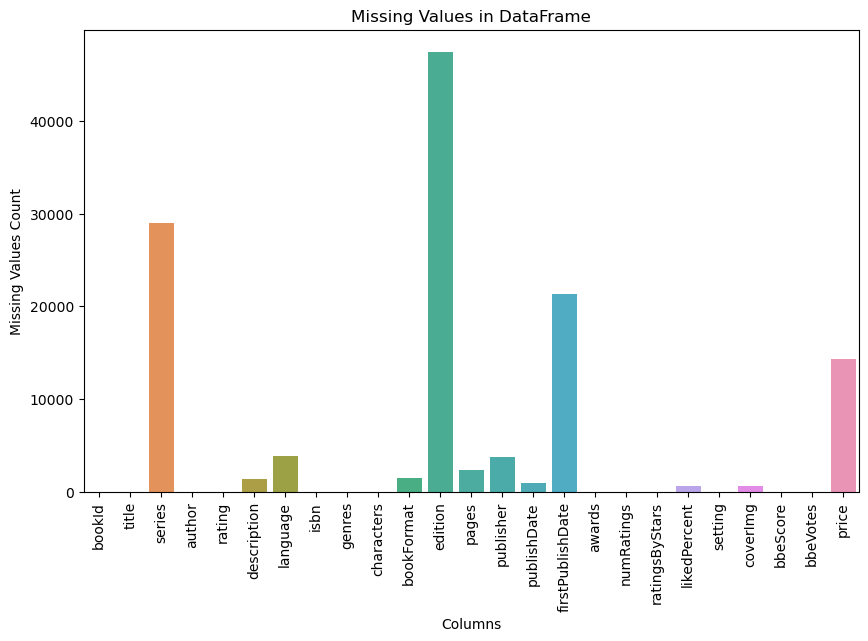

In [94]:
"""Check missing values using sns.barplot to visualize missing values in each column"""
plt.figure(figsize=(10, 6))
sns.barplot(x=df.columns, y=df.isnull().sum())
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Missing Values Count')
plt.title('Missing Values in DataFrame')
plt.show()

In [95]:
"""Save columns with missing values."""
columns_with_missing_values = df.columns[df.isnull().any()].tolist()
columns_with_missing_values

['series',
 'description',
 'language',
 'bookFormat',
 'edition',
 'pages',
 'publisher',
 'publishDate',
 'firstPublishDate',
 'likedPercent',
 'coverImg',
 'price']

In [96]:
"""Fixing missing values."""
df['pages'].fillna(df['pages'].median(), inplace=True)
df['likedPercent'].fillna(df['likedPercent'].median(), inplace=True)
df['price'].fillna(df['price'].median(), inplace=True)
df['series'] = df['series'].fillna('unknown')
df['series'] = df['series'].fillna('unknown')
df['language'] = df['language'].fillna('language')
df['description'] = df['description'].fillna('unknown')
df['publisher'] = df['publisher'].fillna('unknown')
df['coverImg'] = df['coverImg'].fillna('unknown')
df['coverImg'] = df['coverImg'].replace("", "unknown")
df['edition'] = df['edition'].fillna('unknown')
df['bookFormat'] = df['bookFormat'].fillna('unknown')

In [97]:
"""Check for Rows, Nulls and NAs. """
print(df.shape[0], df.isnull().sum().sum(), df.isna().any().sum())

52418 22177 2


In [98]:
df.isnull().sum()

bookId                  0
title                   0
series                  0
author                  0
rating                  0
description             0
language                0
isbn                    0
genres                  0
characters              0
bookFormat              0
edition                 0
pages                   0
publisher               0
publishDate           879
firstPublishDate    21298
awards                  0
numRatings              0
ratingsByStars          0
likedPercent            0
setting                 0
coverImg                0
bbeScore                0
bbeVotes                0
price                   0
dtype: int64

In [99]:
"""Create analyses dictionary to view for cateogrical columns. """
analysis_results_dict = {}

for column in df.columns:
    try:
        results, shortest, longest = analyze_categorical_column(df, column)
        analysis_results_dict[column] = {
            "analysis_results": results,
            "shortest_value": shortest,
            "longest_value": longest
        }
    except Exception as e:
        print(f"Error occurred for column '{column}': {e}")

Error occurred for column 'rating': Can only use .str accessor with string values!
Error occurred for column 'pages': Can only use .str accessor with string values!
Error occurred for column 'numRatings': Can only use .str accessor with string values!
Error occurred for column 'likedPercent': Can only use .str accessor with string values!
Error occurred for column 'bbeScore': Can only use .str accessor with string values!
Error occurred for column 'bbeVotes': Can only use .str accessor with string values!
Error occurred for column 'price': Can only use .str accessor with string values!


In [100]:
df['firstPublishDate'] = pd.to_datetime(df['firstPublishDate'].apply(standardize_date_format), errors='coerce')
df['publishDate'] = pd.to_datetime(df['publishDate'].apply(standardize_date_format), errors='coerce')

df[['firstPublishDate','publishDate']].head(10)

,firstPublishDate,publishDate
32984,1965-11-06,2007-05-25
29560,NaT,1991-10-01
51332,NaT,1993-12-01
36503,NaT,1994-10-01
11517,2012-10-29,2012-10-31
18834,2012-01-01,2012-10-20
5808,2015-06-28,2015-06-04
17663,1933-10-30,1989-03-30
19513,2005-09-21,2005-10-05
47920,1971-11-06,2007-05-01


In [101]:
"""Sometimes first publish date is newer than standard publish date, this means data in columns is inaccurate. To fix this we merge the columns into one, keeping only the older date, drop the original columns and impute the missing values."""
df['oldestPublishDate'] = df[['firstPublishDate', 'publishDate']].min(axis=1)
df = df.drop(['firstPublishDate', 'publishDate'], axis=1)
df['oldestPublishDate'].fillna(df['oldestPublishDate'].median(), inplace=True)

In [102]:
"""Fix the bookId column."""
df['bookId'] = df['bookId'].apply(split_and_get_first)
df['bookId'] = df['bookId'].astype(int)

In [103]:
print(df['bookId'].count() - df['bookId'].nunique())

0


In [104]:
analysis_results_dict['title']['analysis_results']

{'missing_values': 0,
 'unique_values': 49872,
 'total_values': 52418,
 'duplicated_values': 2546,
 'values_with_whitespace': 1,
 'values_with_unusual_chars': 3623,
 'shortest_value_length': 1,
 'longest_value_length': 251,
 'average_value_length': 24.629001488038462}

In [105]:
analysis_results_dict['title']['shortest_value']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
5291,94034.q,q,unknown,"luther blissett, shaun whiteside (translator),...",4.18,"in 1517, martin luther nails his ninety-five t...",english,9780156031967,"['historical fiction', 'fiction', 'historical'...",[],...,10/28/99,['guardian first book award nominee for longli...,6623,"['3131', '2131', '905', '309', '147']",93.0,[],https://i.gr-assets.com/images/s/compressed.ph...,555,7,23.63
18158,7100173,т,unknown,"victor pelevin, виктор пелевин",3.90,"«t» — новый роман писателя, в эпоху которого с...",russian,9785699375158,"['fiction', 'russia', 'modern', 'contemporary'...","['граф т.', 'ариэль', 'кнопф']",...,10/30/09,['большая книга for 3rd place (2010)'],1337,"['464', '439', '307', '91', '36']",91.0,[],https://i.gr-assets.com/images/s/compressed.ph...,100,1,14.93
30187,7737810-z,z,unknown,michael thomas ford,3.63,the first rule of torching: cleanse with fire....,english,9780060737580,"['zombies', 'horror', 'young adult', 'science ...",[],...,NaN,[],697,"['188', '187', '218', '84', '20']",85.0,[],https://i.gr-assets.com/images/s/compressed.ph...,95,1,8.07
49008,415018.v,v,v #1,a.c. crispin,3.88,try to resistthey arrived—tens of thousands of...,english,9780523422374,"['science fiction', 'fiction', 'horror', 'fant...",[],...,1984,[],1317,"['437', '420', '344', '94', '22']",91.0,[],https://i.gr-assets.com/images/s/compressed.ph...,45,1,5.40
22869,18339155-f,f,unknown,daniel kehlmann,3.66,es ist der sommer vor der wirtschaftskrise. ma...,german,9783498035440,"['fiction', 'german literature', 'contemporary...",[],...,10/30/13,['independent foreign fiction prize nominee (2...,2448,"['474', '994', '708', '225', '47']",89.0,[],https://i.gr-assets.com/images/s/compressed.ph...,99,1,4.35
51794,28814866-x,x,unknown,"ilyasah shabazz, kekla magoon (goodreads author)",3.89,winner of the 2016 naacp image award for outst...,language,9780763690922,"['historical fiction', 'young adult', 'fiction...",['malcolm little'],...,january 6th 2015,"[""national book award nominee for young people...",2614,"['689', '1126', '652', '113', '34']",94.0,"['lansing, michigan (united states)', 'boston,...",https://i.gr-assets.com/images/s/compressed.ph...,15,1,2.91
19241,4944389-l,l,unknown,kristy nelwan,3.92,"ava torino, twentysomethinggirl, yang bekerja ...",indonesian,9789790254176,"['romance', 'novels', 'fiction', 'chick lit', ...",['ava torino'],...,10/29/08,[],710,"['229', '264', '160', '42', '15']",92.0,['indonesia'],https://i.gr-assets.com/images/s/compressed.ph...,100,1,5.20
26071,13423043-z,z,unknown,"vassilis vassilikos, βασίλης βασιλικός",4.03,το μυθιστόρημα-ντοκουμέντο για τη δολοφονία το...,"greek, modern (1453-)",9789603644613,"['fiction', 'greece', 'politics', 'historical ...",[],...,11/30/66,[],1005,"['348', '413', '187', '42', '15']",94.0,[],https://i.gr-assets.com/images/s/compressed.ph...,97,1,5.20
27066,27808997-o,o,unknown,eka kurniawan,4.10,tentang seekor monyet yang ingin menikah denga...,indonesian,9786020325590,"['fiction', 'indonesian literature', 'novels',...",[],...,NaN,['kusala sastra khatulistiwa nominee for prosa...,1254,"['420', '595', '194', '39', '6']",96.0,[],https://i.gr-assets.com/images/s/compressed.ph...,97,1,5.20
29002,49386971,φ,unknown,γεώργιος φραγκάκης (goodreads author),4.40,ο φίλιππος βρίσκεται σε κώμα ύστερα από μια απ...,"greek, modern (1453-)",9999999999999,[],[],...,NaN,[],15,"['10', '2', '2', '1', '0']",93.0,[],https://i.gr-assets.com/images/s/compressed.ph...,96,1,5.20


In [106]:
analysis_results_dict['title']['longest_value']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
21883,12862036-novels-by-robin-hobb-including,"novels by robin hobb, including: assassin's ap...",unknown,hephaestus books,4.42,this book consists entirely of reprints of wik...,language,9781244687097,['fantasy'],[],...,NaN,[],73,"['44', '20', '7', '0', '2']",97.0,[],https://i.gr-assets.com/images/s/compressed.ph...,99,1,5.2


In [107]:
non_unique_titles = df[df['title'].duplicated(keep=False)].sort_values(by='title')
non_unique_titles.head(5)

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price,oldestPublishDate
385,11590,'salem's lot,unknown,stephen king (goodreads author),4.03,thousands of miles away from the small townshi...,english,9780450031069,"['horror', 'fiction', 'vampires', 'fantasy', '...","['benjamin mears', 'susan norton', 'matt burke...",...,['world fantasy award nominee for best novel (...,334051,"['122020', '121352', '72184', '14697', '3798']",94.0,"[""jerusalem's lot, maine (united states)""]",https://i.gr-assets.com/images/s/compressed.ph...,28986,393,1.12,1975-10-17
3674,5413,'salem's lot,unknown,"stephen king (goodreads author), jerry n. uels...",4.25,"stephen king's second novel, the vampire bests...",english,9780385516488,"['horror', 'fiction', 'vampires', 'fantasy', '...",[],...,[],94874,"['45186', '31994', '14804', '2313', '577']",97.0,[],https://i.gr-assets.com/images/s/compressed.ph...,873,11,23.39,1975-10-17
27557,7171787,'til death,secret society #3,miasha (goodreads author),4.20,celess is back and hotter than ever in miasha'...,english,9781416589884,['fiction'],[],...,[],183,"['97', '44', '27', '12', '3']",92.0,[],https://i.gr-assets.com/images/s/compressed.ph...,96,1,6.08,2010-08-11
48062,16000978,'til death,rebel ridge #3,sharon sala (goodreads author),4.23,he left in handcuffs. now it's time to set him...,english,9780778314271,"['romantic suspense', 'romance', 'suspense', '...","['lincoln fox', 'meg walker']",...,[],1008,"['476', '341', '149', '28', '14']",96.0,['kentucky (united states)'],https://i.gr-assets.com/images/s/compressed.ph...,52,1,6.55,2013-01-01
11569,7104,1919,the u.s.a. trilogy #2,"john dos passos, e.l. doctorow (foreword by)",3.99,"with 1919, the second volume of his u.s.a. tri...",english,9780618056828,"['fiction', 'classics', 'historical fiction', ...",[],...,[],2536,"['840', '1016', '518', '132', '30']",94.0,['united states of america'],https://i.gr-assets.com/images/s/compressed.ph...,197,3,6.96,1932-10-29


In [108]:
analysis_results_dict['series']['analysis_results']

{'missing_values': 0,
 'unique_values': 22800,
 'total_values': 52418,
 'duplicated_values': 29618,
 'values_with_whitespace': 58,
 'values_with_unusual_chars': 868,
 'shortest_value_length': 1,
 'longest_value_length': 93,
 'average_value_length': 12.361917661871876}

In [109]:
analysis_results_dict['title']['shortest_value']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
5291,94034.q,q,unknown,"luther blissett, shaun whiteside (translator),...",4.18,"in 1517, martin luther nails his ninety-five t...",english,9780156031967,"['historical fiction', 'fiction', 'historical'...",[],...,10/28/99,['guardian first book award nominee for longli...,6623,"['3131', '2131', '905', '309', '147']",93.0,[],https://i.gr-assets.com/images/s/compressed.ph...,555,7,23.63
18158,7100173,т,unknown,"victor pelevin, виктор пелевин",3.90,"«t» — новый роман писателя, в эпоху которого с...",russian,9785699375158,"['fiction', 'russia', 'modern', 'contemporary'...","['граф т.', 'ариэль', 'кнопф']",...,10/30/09,['большая книга for 3rd place (2010)'],1337,"['464', '439', '307', '91', '36']",91.0,[],https://i.gr-assets.com/images/s/compressed.ph...,100,1,14.93
30187,7737810-z,z,unknown,michael thomas ford,3.63,the first rule of torching: cleanse with fire....,english,9780060737580,"['zombies', 'horror', 'young adult', 'science ...",[],...,NaN,[],697,"['188', '187', '218', '84', '20']",85.0,[],https://i.gr-assets.com/images/s/compressed.ph...,95,1,8.07
49008,415018.v,v,v #1,a.c. crispin,3.88,try to resistthey arrived—tens of thousands of...,english,9780523422374,"['science fiction', 'fiction', 'horror', 'fant...",[],...,1984,[],1317,"['437', '420', '344', '94', '22']",91.0,[],https://i.gr-assets.com/images/s/compressed.ph...,45,1,5.40
22869,18339155-f,f,unknown,daniel kehlmann,3.66,es ist der sommer vor der wirtschaftskrise. ma...,german,9783498035440,"['fiction', 'german literature', 'contemporary...",[],...,10/30/13,['independent foreign fiction prize nominee (2...,2448,"['474', '994', '708', '225', '47']",89.0,[],https://i.gr-assets.com/images/s/compressed.ph...,99,1,4.35
51794,28814866-x,x,unknown,"ilyasah shabazz, kekla magoon (goodreads author)",3.89,winner of the 2016 naacp image award for outst...,language,9780763690922,"['historical fiction', 'young adult', 'fiction...",['malcolm little'],...,january 6th 2015,"[""national book award nominee for young people...",2614,"['689', '1126', '652', '113', '34']",94.0,"['lansing, michigan (united states)', 'boston,...",https://i.gr-assets.com/images/s/compressed.ph...,15,1,2.91
19241,4944389-l,l,unknown,kristy nelwan,3.92,"ava torino, twentysomethinggirl, yang bekerja ...",indonesian,9789790254176,"['romance', 'novels', 'fiction', 'chick lit', ...",['ava torino'],...,10/29/08,[],710,"['229', '264', '160', '42', '15']",92.0,['indonesia'],https://i.gr-assets.com/images/s/compressed.ph...,100,1,5.20
26071,13423043-z,z,unknown,"vassilis vassilikos, βασίλης βασιλικός",4.03,το μυθιστόρημα-ντοκουμέντο για τη δολοφονία το...,"greek, modern (1453-)",9789603644613,"['fiction', 'greece', 'politics', 'historical ...",[],...,11/30/66,[],1005,"['348', '413', '187', '42', '15']",94.0,[],https://i.gr-assets.com/images/s/compressed.ph...,97,1,5.20
27066,27808997-o,o,unknown,eka kurniawan,4.10,tentang seekor monyet yang ingin menikah denga...,indonesian,9786020325590,"['fiction', 'indonesian literature', 'novels',...",[],...,NaN,['kusala sastra khatulistiwa nominee for prosa...,1254,"['420', '595', '194', '39', '6']",96.0,[],https://i.gr-assets.com/images/s/compressed.ph...,97,1,5.20
29002,49386971,φ,unknown,γεώργιος φραγκάκης (goodreads author),4.40,ο φίλιππος βρίσκεται σε κώμα ύστερα από μια απ...,"greek, modern (1453-)",9999999999999,[],[],...,NaN,[],15,"['10', '2', '2', '1', '0']",93.0,[],https://i.gr-assets.com/images/s/compressed.ph...,96,1,5.20


In [110]:
analysis_results_dict['title']['longest_value']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
21883,12862036-novels-by-robin-hobb-including,"novels by robin hobb, including: assassin's ap...",unknown,hephaestus books,4.42,this book consists entirely of reprints of wik...,language,9781244687097,['fantasy'],[],...,NaN,[],73,"['44', '20', '7', '0', '2']",97.0,[],https://i.gr-assets.com/images/s/compressed.ph...,99,1,5.2


In [111]:
"""Most series make little sense, and contain multiple values after the first separator, thus proceeding to keep only the series title."""
df['series'] = df['series'].str.split('#', expand = True)[0]
df['series'] = df['series'].str.strip()

df['series'].head(20)

32984                           unknown
29560                           unknown
51332                           unknown
36503                           unknown
11517          the cat's eye chronicles
18834                           unknown
5808                   children of time
17663                           unknown
19513                           unknown
47920                           unknown
36801                           unknown
21689                           unknown
37618                           unknown
36454    chronicles of ancient darkness
17776                           unknown
18489                           unknown
45177                           unknown
46911                           unknown
39539                           unknown
48821                           unknown
Name: series, dtype: string

In [112]:
new_col = 'author'

analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 28198,
 'total_values': 52418,
 'duplicated_values': 24220,
 'values_with_whitespace': 0,
 'values_with_unusual_chars': 4225,
 'shortest_value_length': 2,
 'longest_value_length': 381,
 'average_value_length': 30.1103056202068}

In [113]:
analysis_results_dict[new_col]['shortest_value']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
14844,588066.vice,vice: new and selected poems,unknown,ai,4.12,collected here are poems from ai's previous fi...,english,9780393320183,"['poetry', 'read for school', 'womens', 'liter...",[],...,03/01/99,['national book award for poetry (1999)'],480,"['208', '154', '92', '21', '5']",95.0,[],https://i.gr-assets.com/images/s/compressed.ph...,169,2,5.22
30471,39938003,天觀雙俠（全四卷）,unknown,鄭丰,5.00,趙觀，從小在青樓成長的他，面貌清秀俊雅，個性卻圓滑狡黠、足智多謀，生父不詳的他在親娘被仇...,chinese,9999999999999,[],[],...,NaN,[],1,[],94.0,[],https://i.gr-assets.com/images/s/compressed.ph...,95,1,5.20
36880,32156380-passion-heaven,passion heaven,unknown,籽月,3.29,shu ya-wang is a 28 years-old landscape archit...,chinese,9999999999999,[],[],...,11/06/10,[],7,"['2', '1', '2', '1', '1']",71.0,[],https://i.gr-assets.com/images/s/compressed.ph...,88,1,5.20


In [114]:
analysis_results_dict[new_col]['longest_value']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
47020,15980677-kicking-it,kicking it,alex craft #2.5 - ruby red,"faith hunter (goodreads author) (editor), kala...",3.83,featuring stories by faith hunter * kalayna pr...,english,9780451419002,"['vampires', 'paranormal', 'fantasy', 'antholo...","['luc (chicagoland vampires)', 'lindsey (chica...",...,NaN,[],3064,"['823', '1110', '955', '152', '24']",94.0,[],https://i.gr-assets.com/images/s/compressed.ph...,58,1,5.85


In [115]:
"""Extract roles using a regex pattern matching, then for each unique author, extract roles and append to the all_roles list, add them to a set to keep unique roles list only, exclude from that list any author roles and then apply this pattern and role to remove any names from authors column that are not authors."""
roles_pattern = re.compile(r'\((.*?)\)')
all_roles = []

for author_str in df['author'].dropna().unique():
    roles_found = roles_pattern.findall(author_str)
    all_roles.extend(roles_found)

unique_roles = list(set(all_roles))

authors_roles = ['author', 'goodreads author']

non_authors = [role for role in unique_roles if role not in authors_roles]

df['author'] = df['author'].apply(extract_authors, args=(non_authors,))

df['author'].head(20)


32984                                      peter s. beagle
29560                                      seth a. klarman
51332                                       thomas pynchon
36503                                           r.i. davis
11517                                       t.l. shreffler
18834                                    patrick c. greene
5808                                    adrian tchaikovsky
17663                                                     
19513                                    matthew d. heines
47920                                       diane di prima
36801                                      e.t.a. hoffmann
21689                                       janos wimpffen
37618                                         eiichiro oda
36454                                       michelle paver
17776                                  christopher seufert
18489    janrae frank, jessica amanda salmonson, lyn mc...
45177                                           unica zü

In [116]:
"""Check how many authors should be left in the author column."""
df['author'][df['author'].str.count(',') == 0].count(), df['author'][df['author'].str.count(',') == 1].count(), df['author'][df['author'].str.count(',') == 2].count()

(48332, 3467, 377)

In [117]:
"""Select only the first 2 authors based on choice above."""
df['author'] = df['author'].str.split(',').apply(lambda x: ', '.join(x[:2]) if isinstance(x, list) else x)

In [118]:
new_col = 'description'

analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 50881,
 'total_values': 52418,
 'duplicated_values': 1537,
 'values_with_whitespace': 2348,
 'values_with_unusual_chars': 25037,
 'shortest_value_length': 3,
 'longest_value_length': 24733,
 'average_value_length': 839.5749742454882}

In [119]:
analysis_results_dict[new_col]['shortest_value']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
28866,25657509-train-your-brain,train your brain,unknown,ryuta kawashima,3.84,new,english,9788183224123,"['nonfiction', 'psychology', 'science', 'self ...",[],...,10/30/03,[],135,"['50', '38', '30', '10', '7']",87.0,[],https://i.gr-assets.com/images/s/compressed.ph...,96,1,3.47
28236,5948950,شيء سيبقى بيننا,unknown,فاروق جويدة,3.90,شعر,arabic,9999999999999,"['poetry', 'literature', 'plays', 'love']",[],...,10/30/83,[],2301,"['784', '758', '559', '152', '48']",91.0,[],https://i.gr-assets.com/images/s/compressed.ph...,96,1,5.20
43057,17231104,أحلام الفارس القديم,unknown,صلاح عبد الصبور,3.65,شعر,language,9999999999999,['poetry'],[],...,11/05/64,[],325,"['73', '113', '99', '33', '7']",88.0,[],https://i.gr-assets.com/images/s/compressed.ph...,75,1,5.20
46255,5868421,الرسم بالكلمات,unknown,نزار قباني,3.94,شعر,arabic,9999999999999,"['poetry', 'literature', 'nonfiction', 'love',...",[],...,11/06/66,[],2839,"['1039', '920', '625', '180', '75']",91.0,[],https://i.gr-assets.com/images/s/compressed.ph...,62,1,5.20


In [120]:
analysis_results_dict[new_col]['longest_value']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
18912,17857619-spiritus-mundi,spiritus mundi,spiritus mundi #1,robert sheppard (goodreads author),4.00,"spiritus mundi by robert sheppard, nominated f...",english,9999999999999,[],[],...,NaN,[],14,"['7', '4', '1', '0', '2']",86.0,[],https://i.gr-assets.com/images/s/compressed.ph...,100,1,5.2
22017,17857704-spiritus-mundi---the-romance,spiritus mundi - the romance,spiritus mundi #2,robert sheppard (goodreads author),3.92,"spiritus mundi by robert sheppard, nominated f...",english,b00cgm8bzg,[],[],...,NaN,[],13,"['6', '4', '1', '0', '2']",85.0,[],https://i.gr-assets.com/images/s/compressed.ph...,99,1,5.2


In [121]:
df['description'] = df['description'].str.strip()

In [122]:
new_col = 'language'

analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 82,
 'total_values': 52418,
 'duplicated_values': 52336,
 'values_with_whitespace': 0,
 'values_with_unusual_chars': 12,
 'shortest_value_length': 4,
 'longest_value_length': 37,
 'average_value_length': 7.121771147315807}

In [123]:
analysis_results_dict[new_col]['shortest_value'][new_col]

42242    urdu
24234    urdu
46040    urdu
43603    urdu
6036     urdu
         ... 
42595    urdu
42658    urdu
43007    urdu
43318    urdu
46327    urdu
Name: language, Length: 63, dtype: string

In [124]:
analysis_results_dict[new_col]['longest_value'][new_col]

22126    aromanian; arumanian; macedo-romanian
51230    norwegian nynorsk; nynorsk, norwegian
Name: language, dtype: string

In [125]:
"""Extract unique languages, rank them by frequency, and apply the most common language to each row when multiple languages are present."""
df['language'] = df['language'].str.strip()

languages = df['language'].str.split(';', expand=True).stack().str.strip()
language_ranks = languages.value_counts().index.tolist()

df['language'] = df['language'].apply(most_common_lang, args=(language_ranks,))
df['language'] = df['language'].str.replace(f',', '', regex=True)

df[['bookId', 'language']].tail(10)

,bookId,language
52440,4565266,polish
52450,13501282,english
52457,17977864,english
52461,22925176,english
52462,2613071,persian
52467,40510415,english
52468,33852466,english
52471,12464361,english
52473,11492014,english
52474,11836711,english


In [126]:
"""View ranks."""
language_ranks = {lang: language_ranks.index(lang) + 1 for lang in ["aromanian", "arumanian", "macedo-romanian"] if lang in language_ranks}
language_ranks

{'aromanian': 74, 'arumanian': 75, 'macedo-romanian': 76}

In [127]:
new_col = 'bookFormat'

analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 122,
 'total_values': 52418,
 'duplicated_values': 52296,
 'values_with_whitespace': 5,
 'values_with_unusual_chars': 17,
 'shortest_value_length': 2,
 'longest_value_length': 33,
 'average_value_length': 9.911766950284253}

In [128]:
analysis_results_dict[new_col]['shortest_value'][new_col]

36488    文庫
26921    文庫
Name: bookFormat, dtype: string

In [129]:
analysis_results_dict[new_col]['longest_value'][new_col]

14071    science fiction book club omnibus
Name: bookFormat, dtype: string

In [130]:
"""Clean column, keep only first format from multiple. Not necessarily correct approach, could be done same way as with Authors column."""
df['bookFormat'] = df['bookFormat'].str.strip().str.lower()
df['bookFormat'] = df['bookFormat'].str.split(',').str[0]

In [131]:
"""Creating a list for most commong cases where count exceeds 100. Could be extended to include all cases or uze approximate matching. 
Then map all formats to format mapping, and if the case does not match return it as 'unknown' for ease of management of small formats. 
The .get() returns the value for a given key and default value doesn't have a mapping."""
format_mapping = {
    'e-book': 'ebook',
    'electronic book': 'ebook',
    'ebook': 'ebook',
    'pbk.': 'paperback',
    'soft cover': 'paperback',
    'paperback': 'paperback',
    'mass market paperback': 'paperback',
    'trade paper': 'paperback',
    'book': 'hardcover',
    'hardcover': 'hardcover',
    'hard cover': 'hardcover',
    'board book': 'hardcover',
    'kindle edition': 'kindle edition',
    'audiobook': 'audiobook',
    'unknown': 'unknown',
    'other': 'unknown'
}

df['bookFormat'] = df['bookFormat'].apply(lambda x: format_mapping.get(x, 'unknown'))
df['bookFormat'].value_counts()


paperback         29347
hardcover         12306
kindle edition     5822
ebook              2545
unknown            2291
audiobook           107
Name: bookFormat, dtype: int64

In [132]:
new_col = 'edition'

analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 1690,
 'total_values': 52418,
 'duplicated_values': 50728,
 'values_with_whitespace': 73,
 'values_with_unusual_chars': 416,
 'shortest_value_length': 1,
 'longest_value_length': 229,
 'average_value_length': 7.714716318821779}

In [133]:
analysis_results_dict[new_col]['shortest_value'][new_col]

52374    1
16444    1
20483    1
20849    1
20151    1
        ..
46299    2
49160    1
49421    1
50006    1
50402    2
Name: edition, Length: 202, dtype: string

In [134]:
analysis_results_dict[new_col]['longest_value'][new_col]

49270    || 36η έκδοση (ανατύπωση): 2002. νέα, σχολιασμ...
Name: edition, dtype: string

In [135]:
df['edition'] = df['edition'].str.strip().str.lower()
df['edition'] = df['edition'].str.split(',', expand = True)[0]

In [136]:
"""Alternative handling of case similar to Formats, but without forcing all non-defined cases into 'unknown'."""
edition_mapping = {
    'first edition': 'first edition',
    '1st edition': 'first edition',
    'first': 'first edition',
    '1st': 'first edition',
    '1': 'first edition',
    'second edition': 'second edition',
    '2nd edition': 'second edition',
    '2nd': 'second edition',
    'large print': 'large print',
    'penguin classics': 'penguin classics',
    'penguin classic': 'penguin classics',
    'oxford world\'s classics': 'oxford world classics',
    'unabridged': 'unabridged',
    'revised edition': 'revised edition',
    'omnibus': 'omnibus',
    'abridged': 'abridged',
    'unknown': 'unknown',
    'other': 'unknown'
}

df['edition'] = df['edition'].map(edition_mapping).fillna(df['edition'])

df['edition'].value_counts()


unknown             47470
first edition        1503
second edition        229
large print           104
الطبعة الأولى          99
                    ...  
uncanny x-men           1
loveswept #426          1
1st us                  1
127                     1
norwood editions        1
Name: edition, Length: 1606, dtype: int64

In [137]:
new_col = 'publisher'

analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 10858,
 'total_values': 52418,
 'duplicated_values': 41560,
 'values_with_whitespace': 0,
 'values_with_unusual_chars': 2347,
 'shortest_value_length': 1,
 'longest_value_length': 105,
 'average_value_length': 14.742016101339235}

In [138]:
analysis_results_dict[new_col]['shortest_value'][new_col]

42894    s
37412    q
Name: publisher, dtype: string

In [139]:
analysis_results_dict[new_col]['longest_value'][new_col]

27518    islamic studies scholars

202 books — 146 vote...
Name: publisher, dtype: string

In [140]:
df['publisher'] = df['publisher'].str.strip().str.lower()
df['publisher'] = df['publisher'].str.split(',').str[0]

"""Find publishers that are mentioned more than 100 times, these are then used to build a mapping dictionary."""
publisher_counts = df['publisher'].value_counts()
frequent_publishers = publisher_counts[publisher_counts > 100]

frequent_publishers_df = frequent_publishers.reset_index()
frequent_publishers_df.columns = ['Publisher', 'Count']
frequent_publishers_df = frequent_publishers_df.sort_values(by='Publisher')
frequent_publishers_df


,Publisher,Count
24,ace,195
53,aladdin,128
29,amazon digital services,180
57,anchor,113
49,atria books,136
...,...,...
38,w. w. norton company,163
50,william morrow,136
47,william morrow paperbacks,137
61,zondervan,108


In [141]:
publisher_mapping = {
    "amazon digital services": "amazon",
    "atria books": "atria",
    "ballantine books": "ballantine",
    "berkley": "berkley",
    "berkley books": "berkley",
    "bethany house publishers": "bethany house",
    "createspace": "createspace independent publishing platform",
    "createspace independent publishing platform": "createspace independent publishing platform",
    "harper": "harpercollins",
    "harper perennial": "harpercollins",
    "harpercollins": "harpercollins",
    "harpercollins publishers": "harpercollins",
    "harperteen": "harperteen",
    "hmh books for young readers": "hmh",
    "little, brown and company": "little brown",
    "little, brown books for young readers": "little brown",
    "penguin": "penguin",
    "penguin books": "penguin",
    "penguin classics": "penguin",
    "penguin group (usa)": "penguin",
    "scholastic": "scholastic inc.",
    "scholastic inc.": "scholastic inc.",
    "scholastic paperbacks": "scholastic inc.",
    "scholastic press": "scholastic inc.",
    "simon & schuster": "simon and schuster",
    "simon pulse": "simon and schuster",
    "simon schuster": "simon and schuster",
    "simon schuster books for young readers": "simon and schuster",
    "st. martin's griffin": "st. martin",
    "st. martin's paperbacks": "st. martin",
    "st. martin's press": "st. martin",
    "william morrow": "william morrow",
    "william morrow paperbacks": "william morrow"
}

df['publisher'] = df['publisher'].map(publisher_mapping).fillna(df['publisher'])

df['publisher'].head(5)

32984            centro books
29560           harpercollins
51332               viking pr
36503    players press (u.k.)
11517         the runaway pen
Name: publisher, dtype: object

In [142]:
"""There are multuple formats in ISBN column, though ISBN should be only numbers, so ignore any that have anything other than numbers."""
try:
    df['isbn'] = pd.to_numeric(df['isbn'], errors='coerce')
    df['isbn'] = df['isbn'].fillna(9999999999999)
    df['isbn'] = df['isbn'].astype(int)
except Exception as e:
    print(f"Error occurred: {e}")

df['isbn'].head()

32984    9781933572079
29560    9780887305108
51332    9780670742240
36503    9780887346484
11517    9780985166342
Name: isbn, dtype: int64

In [143]:
duplicates = df[df.duplicated(subset=['isbn', 'title', 'author', 'edition'], keep=False)].sort_values(by='isbn')
duplicates['isbn'].count(), duplicates[['isbn', 'title', 'author']].head(6)

(16,
                 isbn                 title                         author
 9439   9999999999999  the dark god's bride  dahlia lu,  dahlia l. summers
 9483   9999999999999  the dark god's bride  dahlia lu,  dahlia l. summers
 12004  9999999999999     limits of destiny             sharlyn g. branson
 12180  9999999999999     limits of destiny             sharlyn g. branson
 12498  9999999999999     limits of destiny             sharlyn g. branson
 12781  9999999999999     limits of destiny             sharlyn g. branson)

In [144]:
df = df.drop_duplicates(subset=['title', 'author', 'description'], keep='first')

In [145]:
"""Convert column from a string to a list, then create a new column counting number of awards. Keep only 5 awards for now."""
df['awards'] = df['awards'].apply(convert_string_to_list)
df['num_awards'] = df['awards'].apply(len)
df['awards'] = df['awards'].apply(lambda x: x[:5] if isinstance(x, list) else [])
df[['awards', 'num_awards']].head(10)

,awards,num_awards
32984,[],0
29560,[],0
51332,[],0
36503,[],0
11517,[],0
18834,[],0
5808,"[arthur c. clarke award (2016), grand prix de ...",2
17663,[],0
19513,[],0
47920,[],0


In [146]:
df['characters'] = df['characters'].apply(convert_string_to_list)
df['num_characters'] = df['characters'].apply(len)
df['characters'] = df['characters'].apply(lambda x: x[:3] if isinstance(x, list) else [])
df['characters'] = df['characters'].astype(str).apply(remove_brackets_content)
df[['characters', 'num_characters']].tail(10)

,characters,num_characters
52440,[],0
52450,"['giovanni ""gio"" bravo']",1
52457,[],0
52461,[],0
52462,[],0
52467,[],0
52468,[],0
52471,[],0
52473,[],0
52474,[],0


In [147]:
"""Also removing duplicate genre's from the setting list."""
df['setting'] = df['setting'].apply(convert_string_to_list)
df['num_setting'] = df['setting'].apply(len)
df['setting'] = df['setting'].apply(lambda x: list(set([setting.lower().strip() for setting in x])) if isinstance(x, list) else x)
df['setting'] = df['setting'].apply(lambda x: x[:5] if isinstance(x, list) else [])
df['setting'] = df['setting'].astype(str).apply(remove_brackets_content)
df[['setting', 'num_setting']].tail(10)

,setting,num_setting
52440,['afghanistan'],1
52450,[],0
52457,[],0
52461,[],0
52462,[],0
52467,[],0
52468,[],0
52471,[],0
52473,[],0
52474,[],0


In [148]:
df['genres'] = df['genres'].apply(convert_string_to_list)
df['genres'] = df['genres'].apply(lambda x: list(set([genre.lower().strip() for genre in x])) if isinstance(x, list) else x)
df['num_genres'] = df['genres'].apply(len)
df[['genres', 'num_genres']].head(10)

,genres,num_genres
32984,"[travelogue, biography memoir, memoir, autobio...",7
29560,"[money, business, self help, economics, financ...",8
51332,[fiction],1
36503,[fashion],1
11517,"[paranormal, romance, fantasy romance, fiction...",10
18834,"[suspense, paranormal, fiction, fantasy, horro...",10
5808,"[science fiction fantasy, post apocalyptic, sp...",10
17663,"[writing, language, reference, dictionaries, h...",7
19513,[],0
47920,"[feminism, poetry, womens, politics]",4


In [149]:
"""Replace negative values in 'bbeVotes' column with 0."""
df.loc[df['bbeVotes'] < 0, 'bbeVotes'] = 0
df[['bbeScore','rating']][df['bbeScore'] == 0]

,bbeScore,rating
52472,0,4.16
52475,0,3.70
52470,0,4.14
52477,0,4.02
52476,0,3.85
52471,0,4.07
52473,0,4.00
52474,0,4.19


# Updating columns, Correlation matrix and Outlier checks

In [150]:
"""Checking lengths to know how long the VARCHARs have to be for Databse columns."""
categorical_cols = df.select_dtypes(include=['object', 'string']).columns

for column in categorical_cols:
    print(column, df[column].str.len().max())

title 251
series 90
author 87
description 24733
language 28
genres 10
characters 175
bookFormat 14
edition 82
publisher 105
awards 5
ratingsByStars 53
setting 188
coverImg 108


In [151]:
"""Create normal bookId. It's already unique and there will be no data loss doing this, but will allow normal serialization in MySQL database."""
df = df.sort_index()
df['bookId'] = range(1, len(df) + 1)

"""Shortening columns to save space and for computational efficiency."""
df['title'] = df['title'].str[:50]
df['series'] = df['series'].str[:30]
df['description'] = df['description'].str[:250]
df['edition'] = df['edition'].str[:30]
df['publisher'] = df['publisher'].str[:30]
df['coverImg'] = df['publisher'].str[10]


In [152]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = ['title', 'series', 'bookFormat', 'edition', 'publisher']
numerical_cols.remove('bookId')
numerical_cols.remove('isbn')
numerical_cols

['rating',
 'pages',
 'numRatings',
 'likedPercent',
 'bbeScore',
 'bbeVotes',
 'price',
 'num_awards',
 'num_characters',
 'num_setting',
 'num_genres']

In [153]:
desc_stats = df[numerical_cols].describe().T
desc_stats["mode"] = df[numerical_cols].mode().iloc[0]
desc_stats

,count,mean,std,min,25%,50%,75%,max,mode
rating,52418.0,4.021828,0.36706,0.0,3.82,4.03,4.23,5.0,4.0
pages,52418.0,327.563871,246.541716,0.0,217.0,304.0,385.0,14777.0,304.0
numRatings,52418.0,17886.220058,103993.333506,0.0,341.0,2310.5,9388.25,7048471.0,2.0
likedPercent,52418.0,92.252947,5.955635,0.0,90.0,94.0,96.0,100.0,94.0
bbeScore,52418.0,1986.11807,35173.199057,0.0,84.0,97.0,187.0,2993816.0,100.0
bbeVotes,52418.0,22.554046,369.368931,0.0,1.0,1.0,2.0,30516.0,1.0
price,52418.0,8.437262,20.808974,0.84,3.72,5.2,6.57,898.64,5.2
num_awards,52418.0,0.429471,1.270468,0.0,0.0,0.0,0.0,41.0,0.0
num_characters,52418.0,1.400931,6.793336,0.0,0.0,0.0,1.0,669.0,0.0
num_setting,52418.0,0.330955,1.097274,0.0,0.0,0.0,0.0,135.0,0.0


In [154]:
"""Mapping for column names and types, because some dtypes changed due to manipulations in EDA, especially one containing lists."""
columns_dict = {
                'language': 'string',
                'bookFormat': 'string',
                'edition': 'string',
                'publisher': 'string',
                'characters': 'string',
                'awards': 'string',
                'author': 'string',
                'setting': 'string',
                'genres': 'string',
                'bookFormat': 'string',
                'edition': 'string',
                'publisher': 'string',
                'oldestPublishDate': 'datetime64[ns]'
                }

for column, dtype in columns_dict.items():
    try:
        df[column] = df[column].astype(dtype)
    except ValueError:
        print(f'Column {column} dtype change failed!')

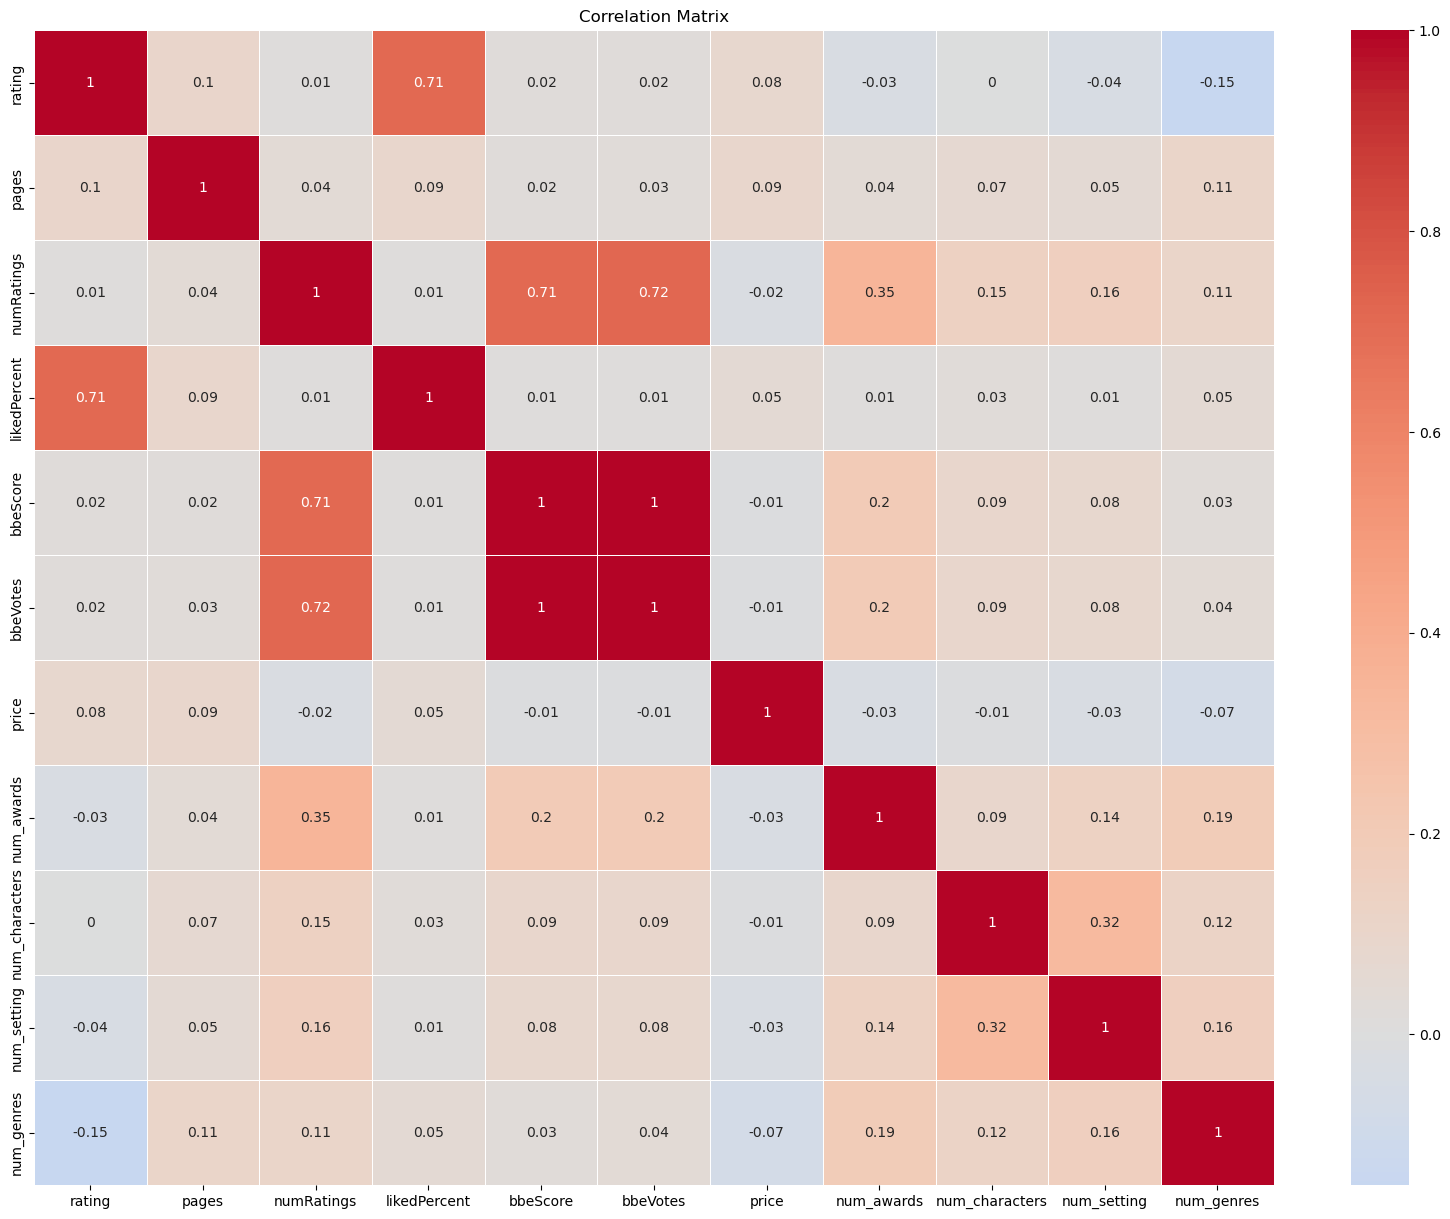

In [155]:
"""
Computing correlation matrix between numerical columns and plotting it for ease of visualization. 
Some columns are highly correlated with one another, which makes sense because a votes and ratings are associated.
"""
corr_matrix = df[numerical_cols].corr().round(2)

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


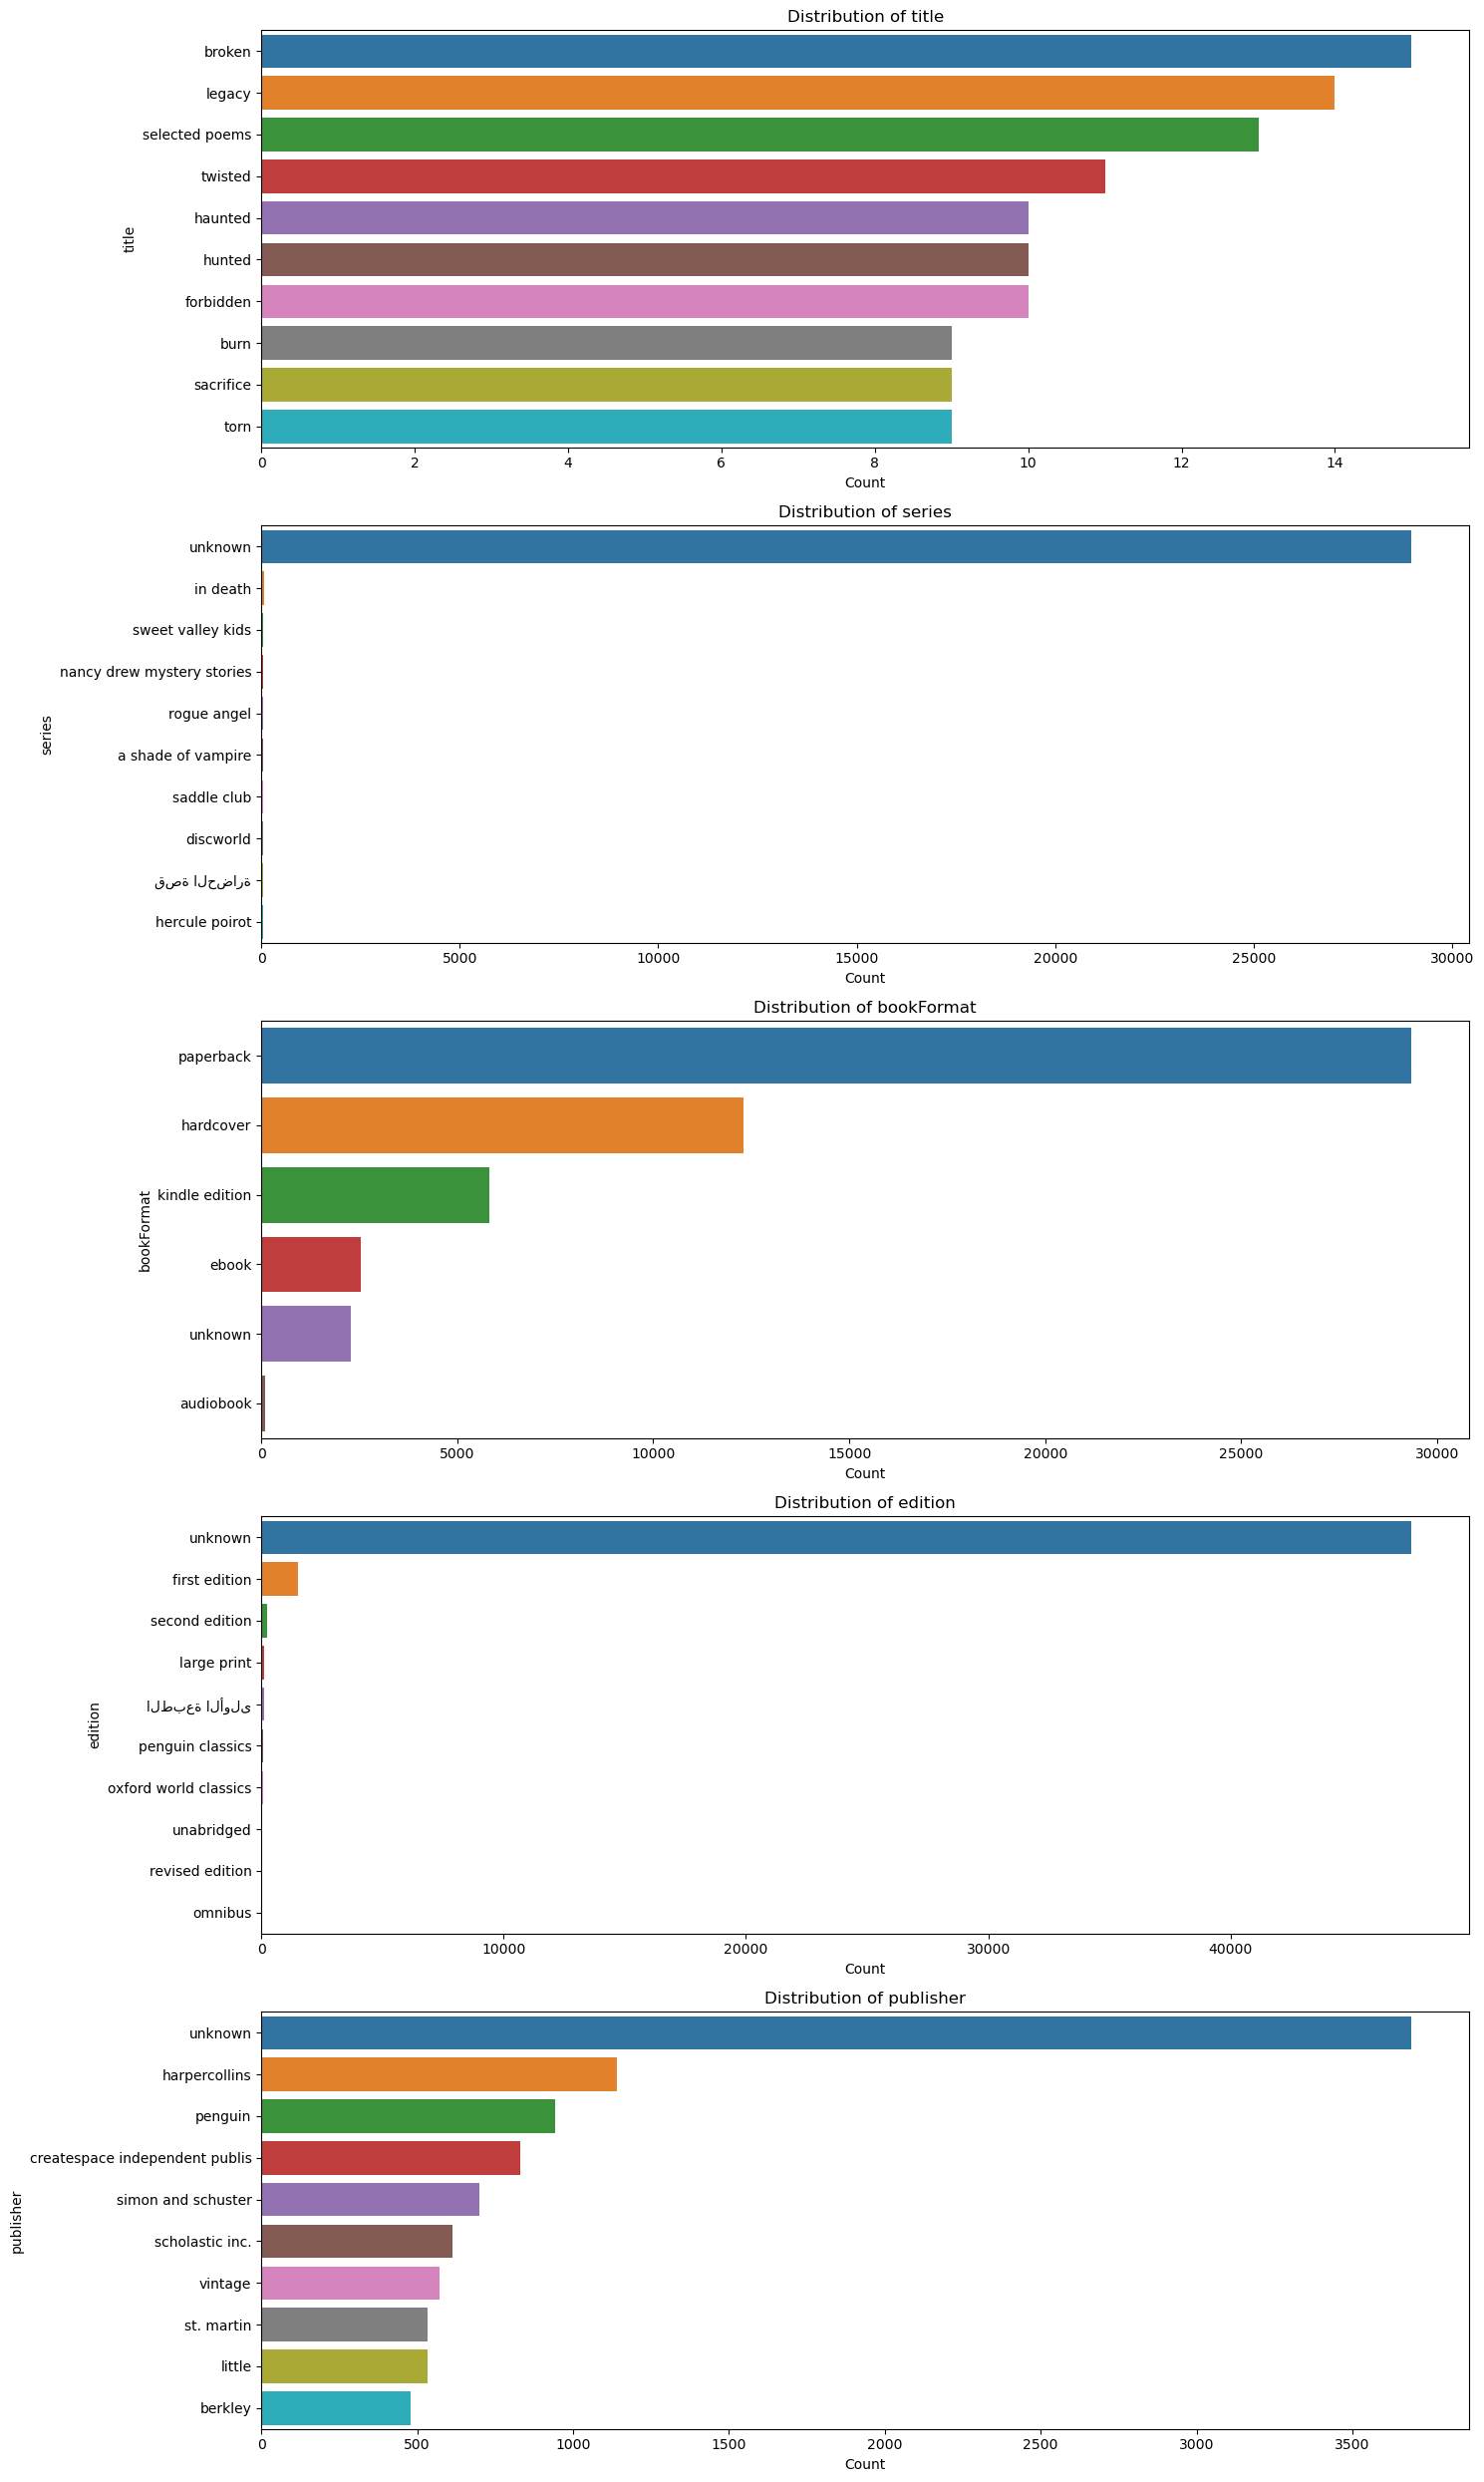

In [156]:
""" Plotting categorical Columns, first 10 values only."""
plt.figure(figsize=(15, 5 * len(categorical_cols)))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    sns.countplot(data=df, y=col, order=df[col].value_counts().index[:10])
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [157]:
"""View columns with missing values."""
columns_with_missing_values = df.columns[df.isnull().any()].tolist()
columns_with_missing_values


['coverImg']

In [160]:
df.isnull().sum()

bookId               0
title                0
series               0
author               0
rating               0
description          0
language             0
isbn                 0
genres               0
characters           0
bookFormat           0
edition              0
pages                0
publisher            0
awards               0
numRatings           0
ratingsByStars       0
likedPercent         0
setting              0
coverImg             0
bbeScore             0
bbeVotes             0
price                0
oldestPublishDate    0
num_awards           0
num_characters       0
num_setting          0
num_genres           0
dtype: int64

In [159]:
df['coverImg'] = df['coverImg'].replace("", "unknown")
df['coverImg'] = df['coverImg'].fillna('unknown')

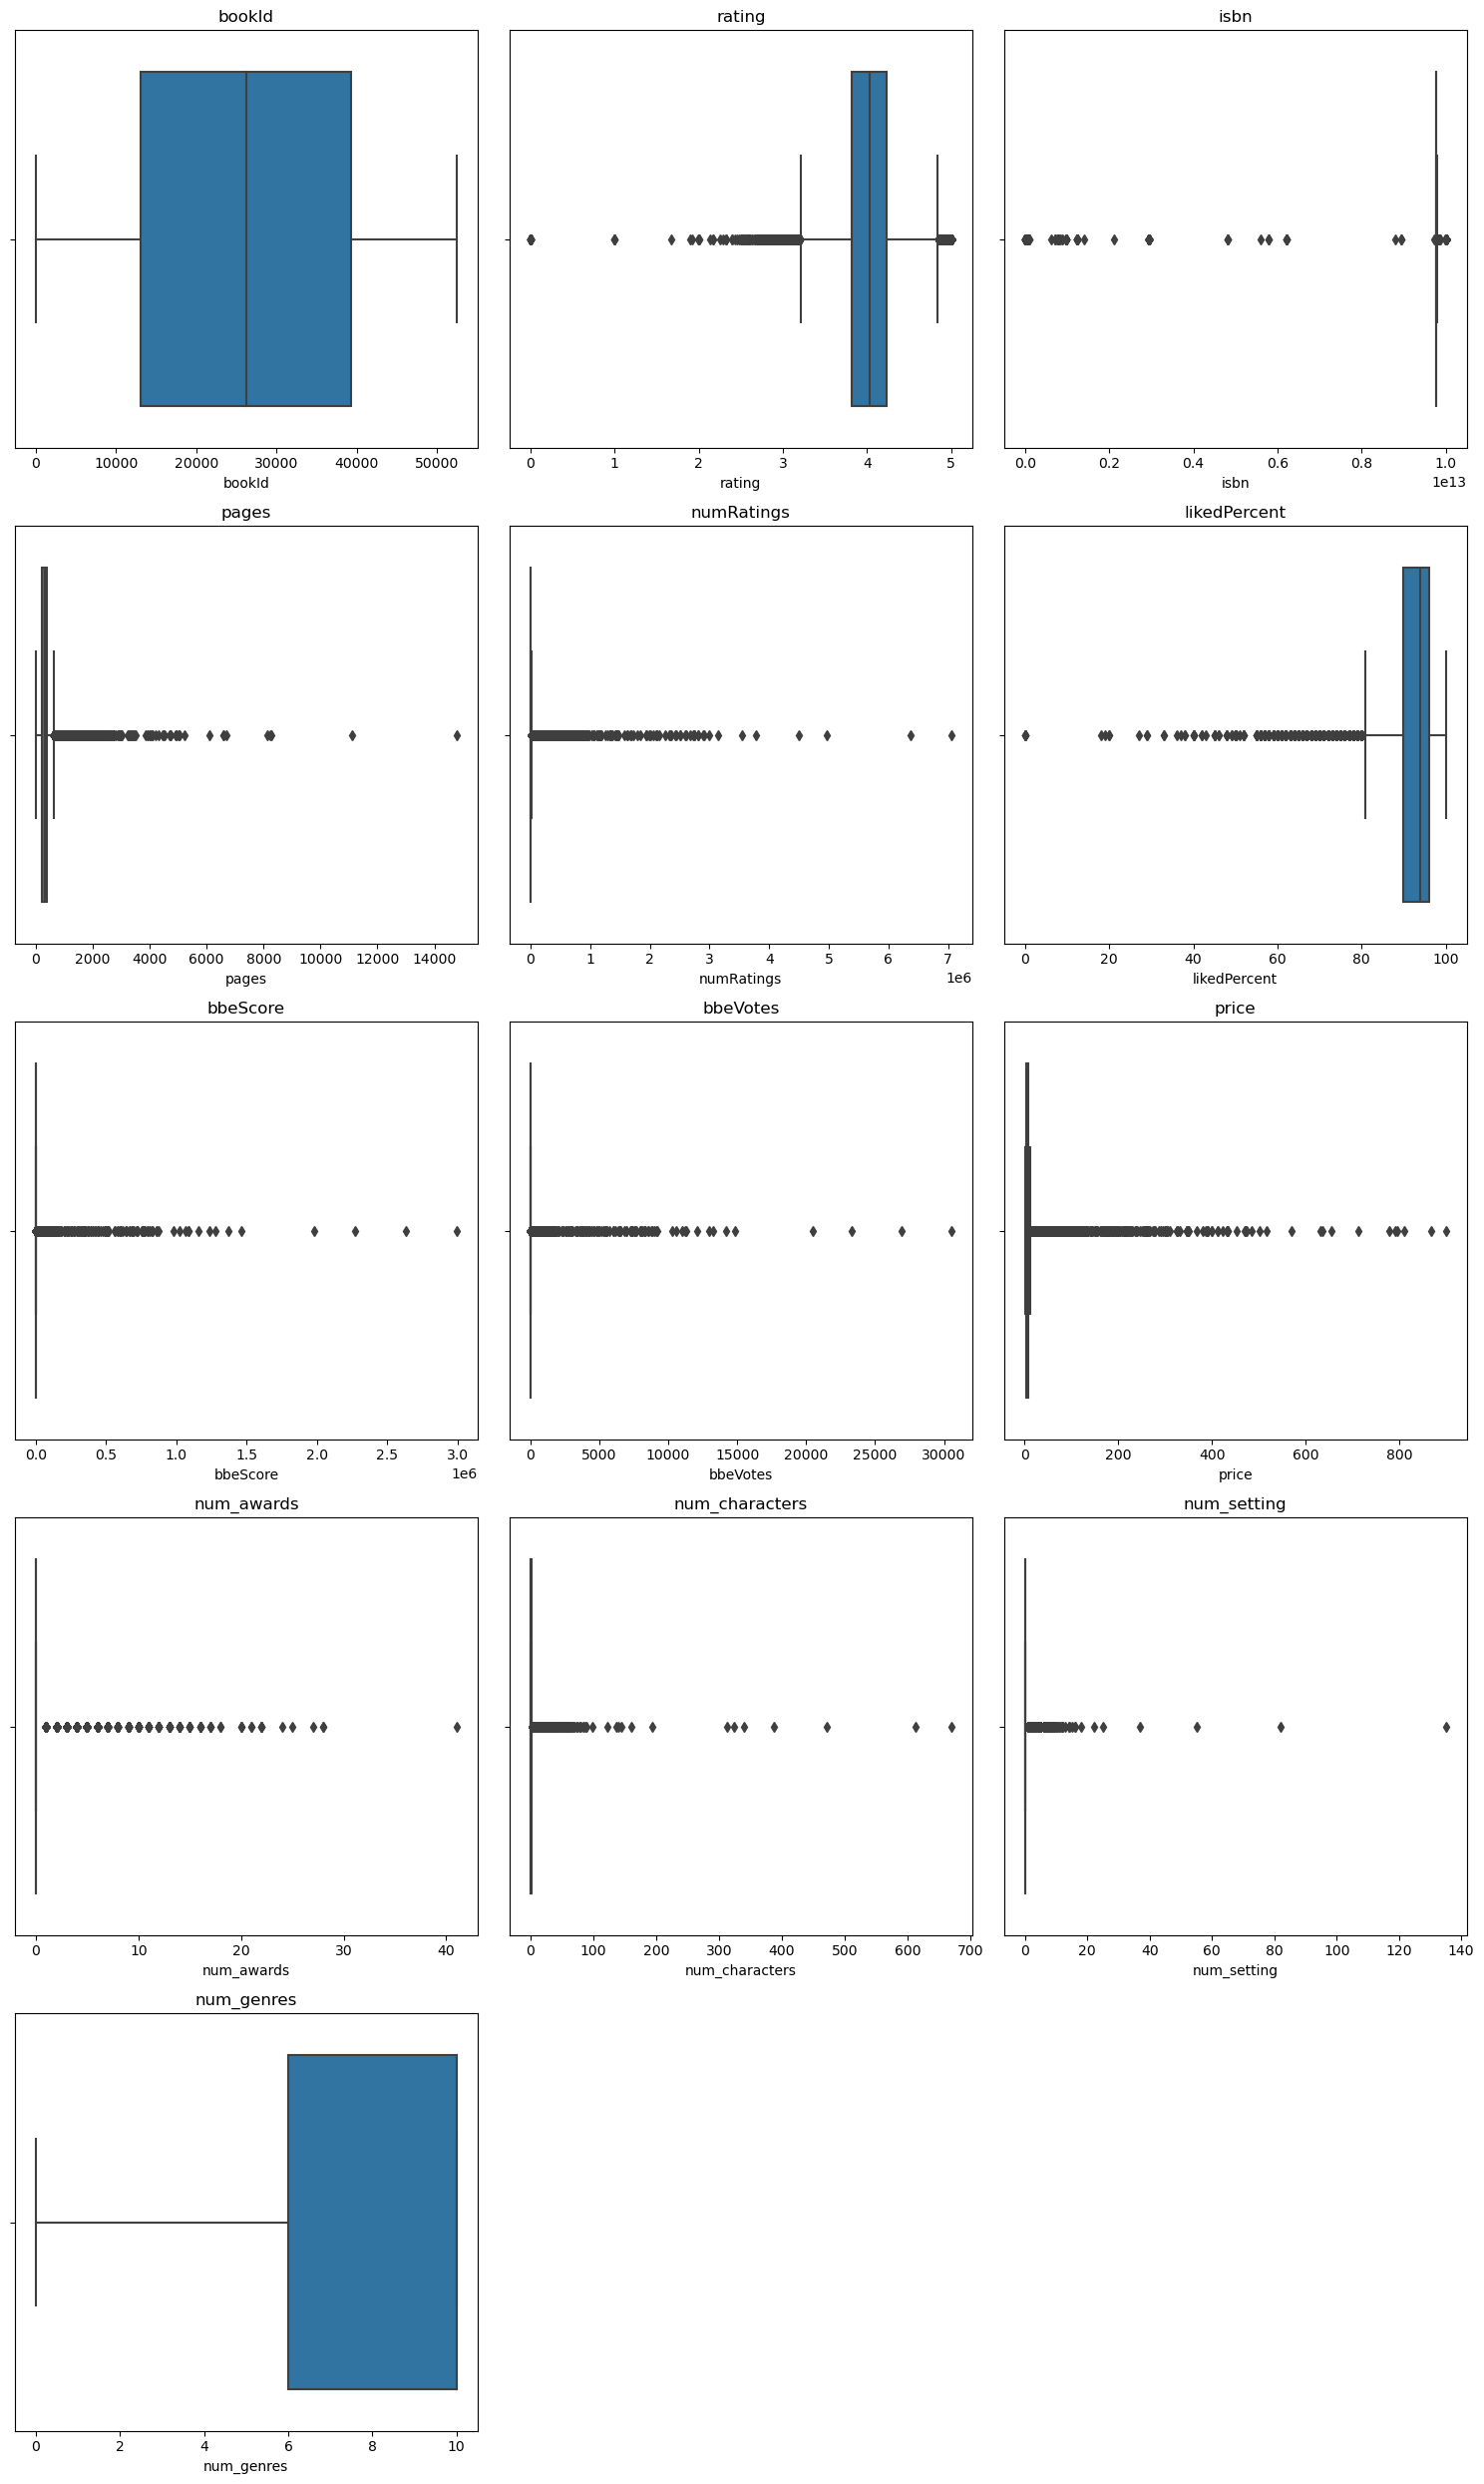

In [161]:
"""Graphical investigation of numerical columns for outliers."""
outliers_numerical_cols(df)

In [162]:
"""Create a list with outliers columns."""
outliers_columns = []

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    if outlier_cols(df[col]):
        outliers_columns.append(col)

outliers_columns.remove('isbn')
outliers_columns


['rating',
 'pages',
 'numRatings',
 'likedPercent',
 'bbeScore',
 'bbeVotes',
 'price',
 'num_awards',
 'num_characters',
 'num_setting']

In [163]:
"""Apply winsorization to columns with outliers in order to force extreme values into nearest acceptable value."""
for col in outliers_columns:
    df = winsorize(df, col)

In [164]:
df[outliers_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
rating,52418.0,4.026894,0.333839,3.0,3.82,4.03,4.23,5.0
pages,52418.0,312.013106,139.282717,76.0,217.0,304.0,385.0,629.0
numRatings,52418.0,9307.211759,15902.313242,11.0,341.0,2310.5,9388.25,61420.0
likedPercent,52418.0,92.575909,4.571946,82.0,90.0,94.0,96.0,99.0
bbeScore,52418.0,225.267217,326.585567,38.0,84.0,97.0,187.0,1386.0
bbeVotes,52418.0,2.840646,4.207924,1.0,1.0,1.0,2.0,18.0
price,52418.0,6.600132,4.732086,2.0,3.72,5.2,6.57,21.0
num_awards,52418.0,0.291026,0.619574,0.0,0.0,0.0,0.0,2.0
num_characters,52418.0,0.969095,1.987733,0.0,0.0,0.0,1.0,7.0
num_setting,52418.0,0.281659,0.569486,0.0,0.0,0.0,0.0,2.0


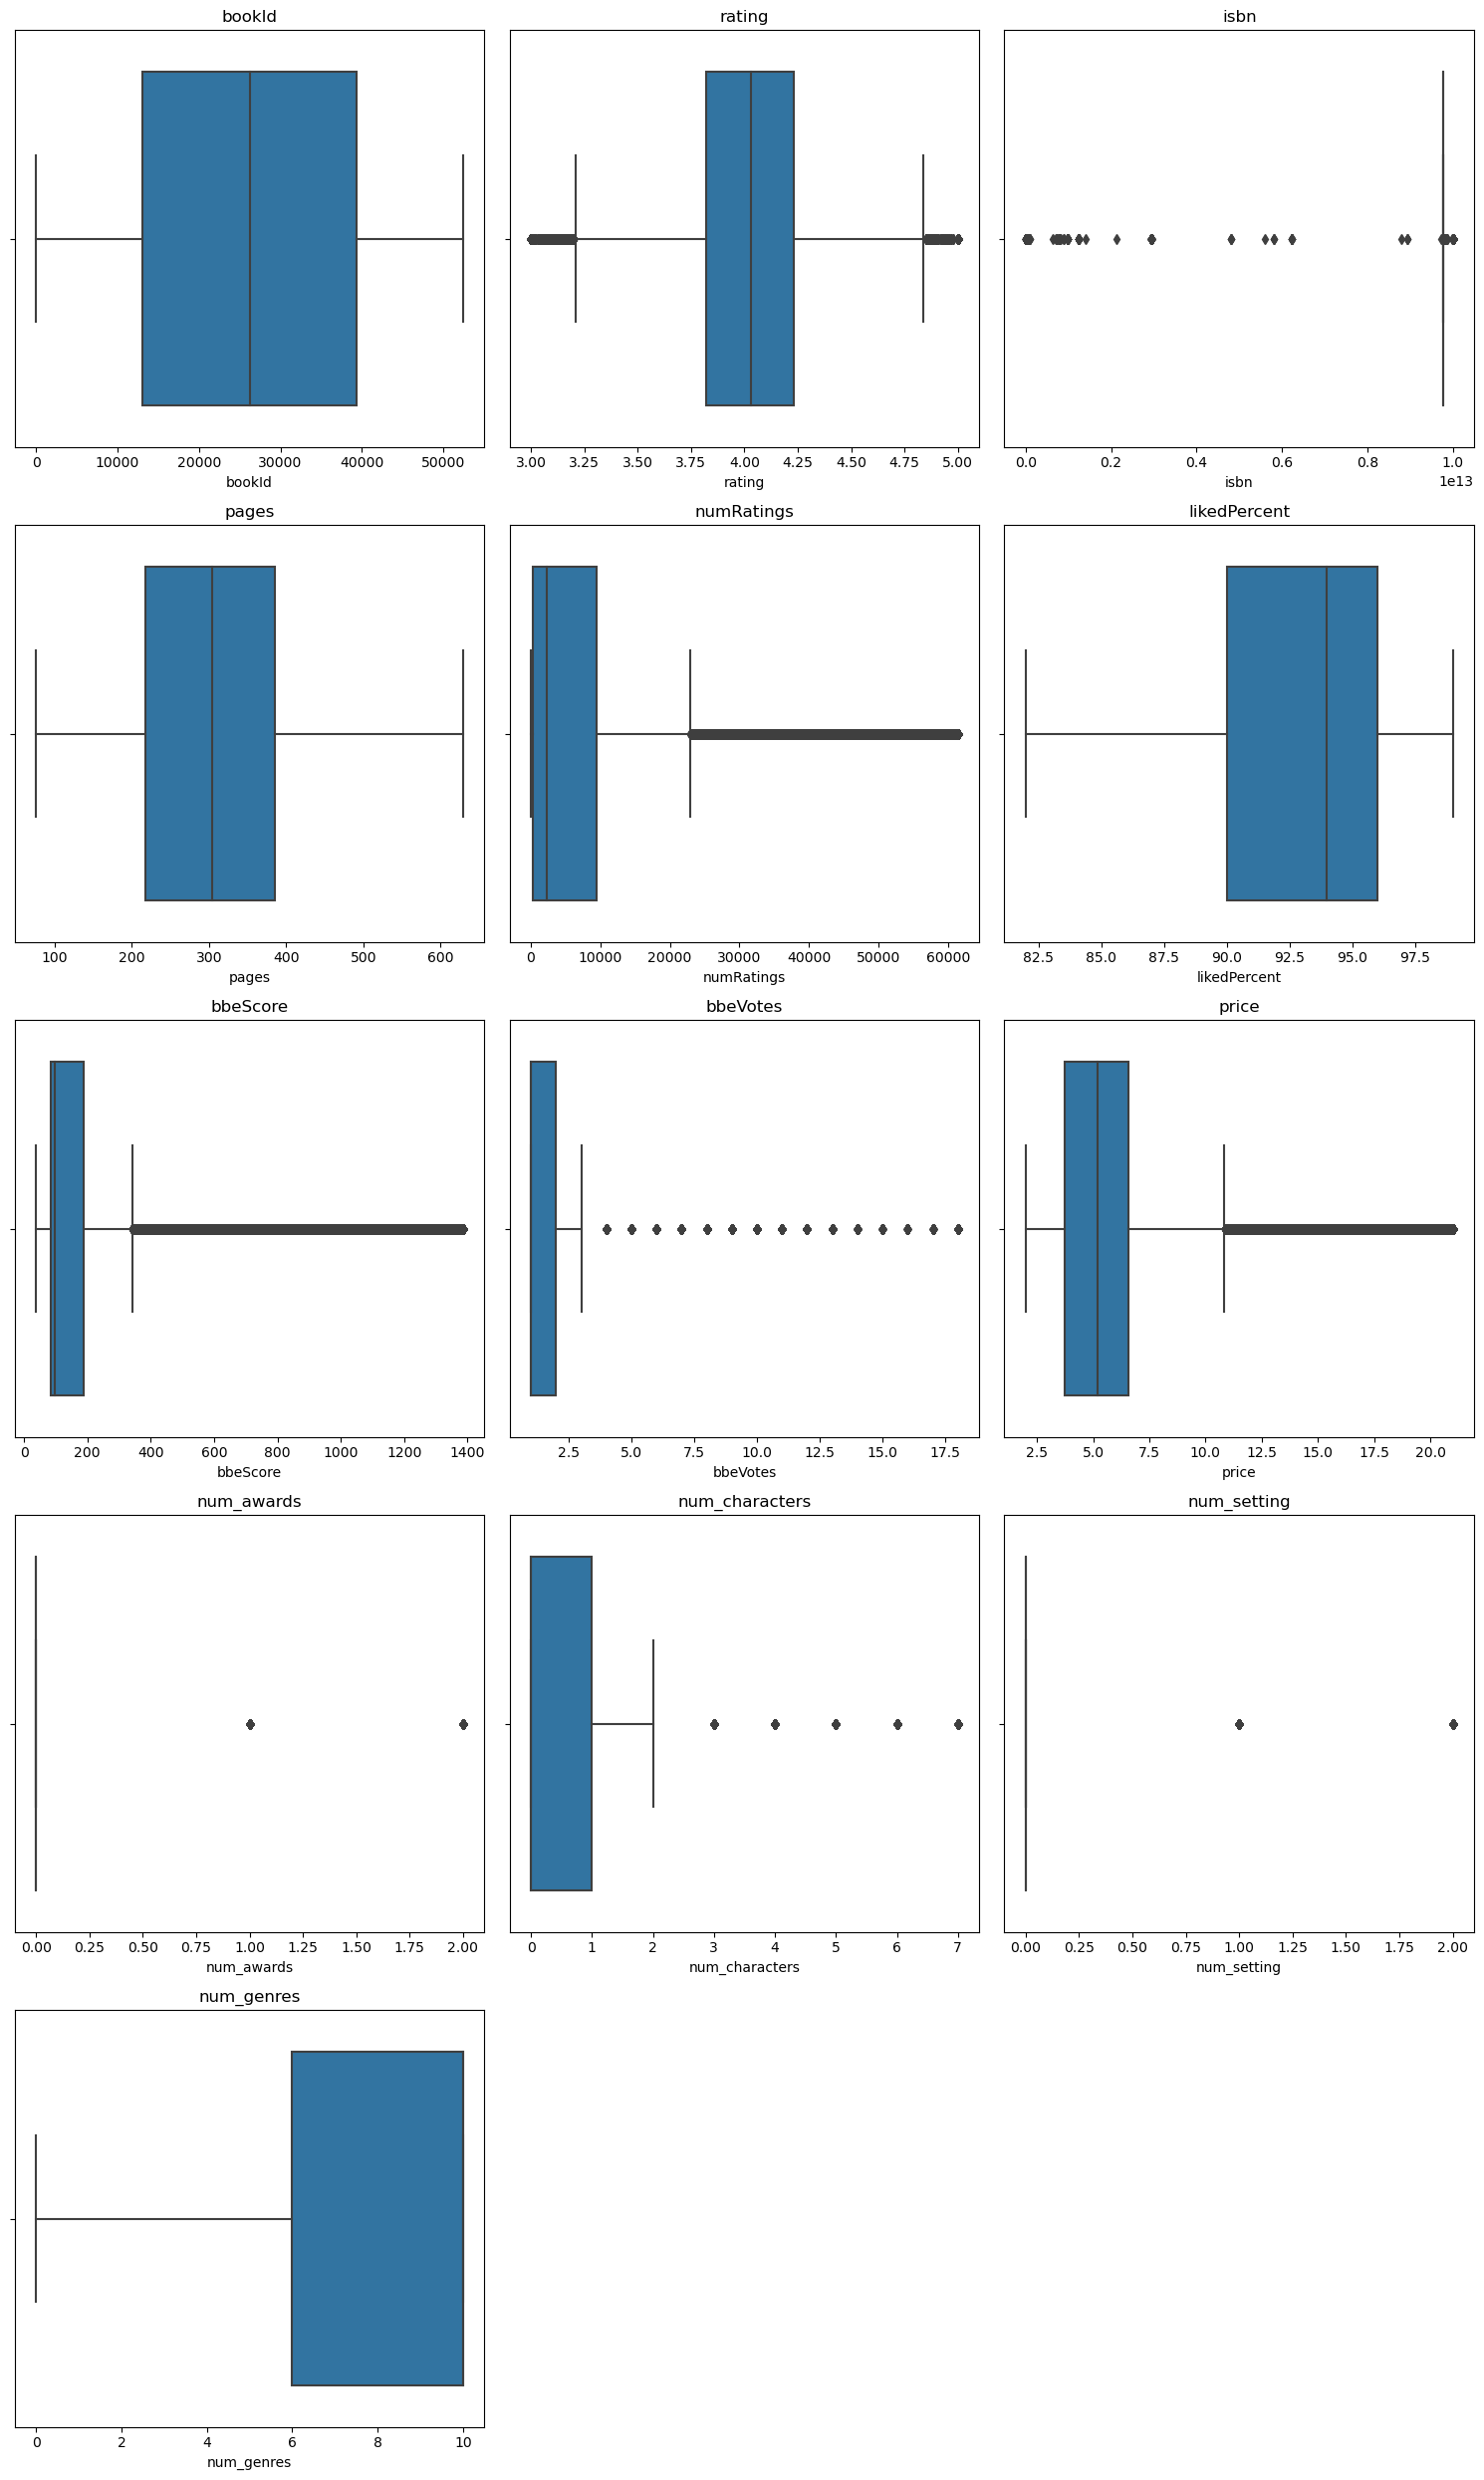

In [165]:
outliers_numerical_cols(df)

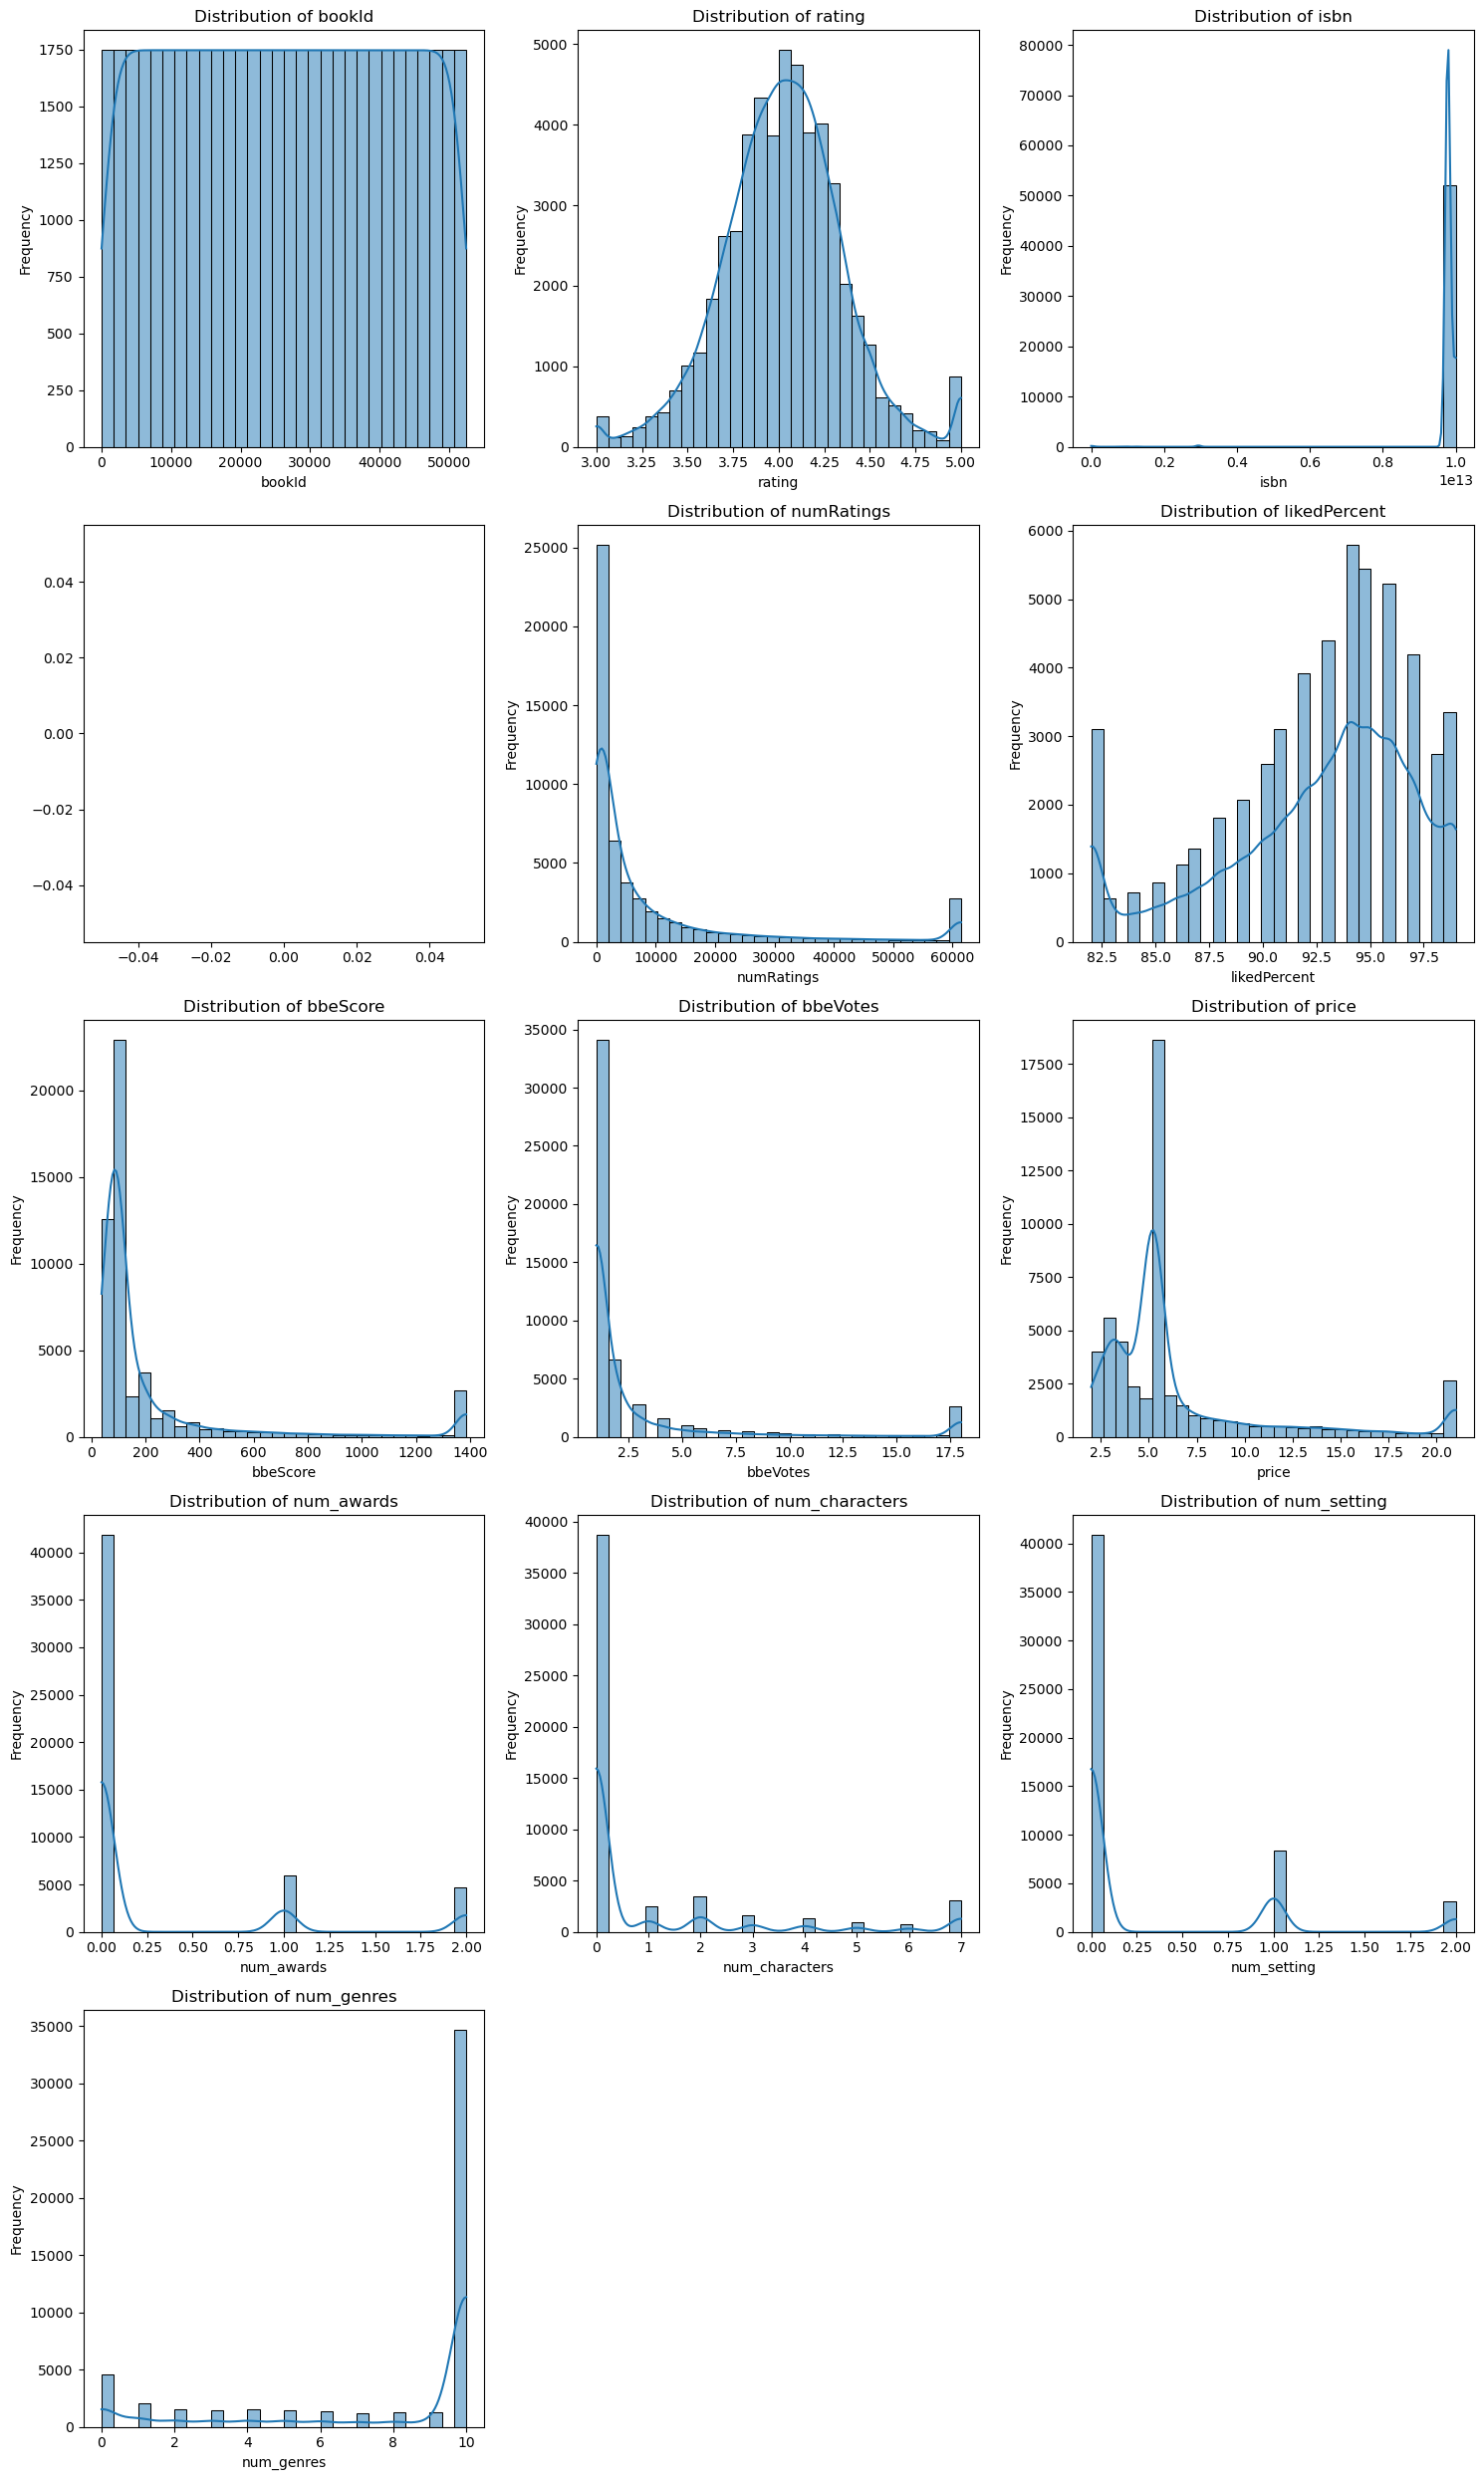

In [166]:
"""View distribution of numerical columns after removal of outliers."""
distribution_numerical_cols(df)

# Save data before Normalization

In [ ]:
df.memory_usage(deep=True) / (1024 * 1024)  # Convert bytes to MB

In [ ]:
# Before NORMALIZATION
df['description'] = df['description'].str[:5] # Only for the description to be saved
df['coverImg'] = df['coverImg'].str[:5] # Only for the description to be saved
file_path = "/Volumes/Workspace/Turing_College/1.3_project/before_normalization.csv"
df.to_csv(file_path, index=False)


In [ ]:
"""Import and load the data into a dataframe."""
# data = pd.read_csv("cleaned_best_books_ever.csv")
data = pd.read_csv("before_normalization.csv")
df = pd.DataFrame(data)

# Normalization

In [167]:
"""Normalize all remaining columns and split them off into separate tables, which will later be used to create MySQL tables and upload data."""
genres_df = explode_column_to_table(df, 'genres', 'genreName')
authors_df = explode_column_to_table(df, 'author', 'authorName')
characters_df = explode_column_to_table(df, 'characters', 'characterName')
settings_df = explode_column_to_table(df, 'setting', 'settingName')
awards_df = explode_column_to_table(df, 'awards', 'awardName')

isbn_df = df[['bookId', 'isbn']].copy()
languages_df = df[['bookId', 'language']].copy()

df = df.drop('isbn', axis=1)
df = df.drop('language', axis=1)
books_df = df.copy()

In [168]:
"""Spliting 'ratingsByStars' column into five separate columns, replace missing values with 0 and convert to numeric."""
ratings_columns = ['rating_5_star', 'rating_4_star', 'rating_3_star', 'rating_2_star', 'rating_1_star']
df['ratingsByStars'] = df['ratingsByStars'].apply(convert_string_to_list)
df[ratings_columns] = pd.DataFrame(df['ratingsByStars'].tolist(), index=df.index).fillna(0).astype(int)
df.drop(columns=['ratingsByStars'], inplace=True)


In [169]:
ratings_columns = [
    'bookId', 'rating', 'numRatings', 'likedPercent',
    'bbeScore', 'bbeVotes', 'rating_5_star', 'rating_4_star',
    'rating_3_star', 'rating_2_star', 'rating_1_star'
]

ratings_df = df[ratings_columns].copy()

ratings_columns.remove('bookId')
df = df.drop(columns=ratings_columns)

"""Compute the 'totalScore' column, 'totalVotes' and 'performanceScore' columns that could then be used for ML instead of many other columns individually. This is a basic calculation, a more sophisticated method for calculating could be implemented."""
ratings_df['totalScore'] = (
    ratings_df['rating'] * 
    ratings_df['bbeScore'] * 
    ratings_df['likedPercent']
)

ratings_df['totalVotes'] = (
    ratings_df['numRatings'] * 
    ratings_df['bbeVotes']
)

ratings_df['performanceScore'] = ratings_df['totalScore'] / ratings_df['totalVotes']

ratings_df = ratings_df.fillna(0)

ratings_df.head(5)


,bookId,rating,numRatings,likedPercent,bbeScore,bbeVotes,rating_5_star,rating_4_star,rating_3_star,rating_2_star,rating_1_star,totalScore,totalVotes,performanceScore
0,1,4.33,61420,96.0,1386,18,3444695,1921313,745221,171994,93557,576132.48,1105560,0.521123
1,2,4.50,61420,98.0,1386,18,1593642,637516,222366,39573,14526,611226.00,1105560,0.552866
2,3,4.28,61420,95.0,1386,18,2363896,1333153,573280,149952,80794,563547.60,1105560,0.509739
3,4,4.26,61420,94.0,1386,18,1617567,816659,373311,113934,76770,555009.84,1105560,0.502017
4,5,3.60,61420,82.0,1386,18,1751460,1113682,1008686,542017,548674,409147.20,1105560,0.370081


# Creating ID fields

In [ ]:
"""genres_df = factorize_id(genres_df, 'genreName', id_field='genresId')
authors_df = factorize_id(authors_df, 'authorName', id_field='authorsId')
characters_df = factorize_id(characters_df, 'characterName', id_field='charactersId')
settings_df = factorize_id(settings_df, 'settingName', id_field='settingsId')
awards_df = factorize_id(awards_df, 'awardName', id_field='awardsId')
languages_df = factorize_id(languages_df, 'language', id_field='languagesId')
isbn_df = factorize_id(isbn_df, 'isbn', id_field='isbnId')
ratings_df = factorize_id(ratings_df, 'totalScore', 'totalVotes', 'performanceScore', id_field='ratingsId')
"""

# Uploading data directly to MySQL

In [170]:
"""Imported connection data used to connect to MySQL without. Then creating a database 'books' and renewing engine to include database."""
engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/")

with engine.connect() as conn:
    conn.execute(text(f"CREATE DATABASE IF NOT EXISTS {database}"))
conn.close()

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")


In [171]:
"""Create SQLAlchemy classes with functions defined in functions_all.py."""
Base = declarative_base()
Book = mysql_class_from_df_pk(books_df, 'books', 'bookId')

In [172]:
"""Check what 'create_all' would create in the 'books' table"""
print(CreateTable(Book.__table__).compile(engine))



CREATE TABLE books (
	`bookId` BIGINT NOT NULL AUTO_INCREMENT, 
	title VARCHAR(300), 
	series VARCHAR(300), 
	rating FLOAT, 
	description VARCHAR(300), 
	`bookFormat` VARCHAR(300), 
	edition VARCHAR(300), 
	pages BIGINT, 
	publisher VARCHAR(300), 
	`numRatings` BIGINT, 
	`ratingsByStars` VARCHAR(300), 
	`likedPercent` FLOAT, 
	`coverImg` VARCHAR(300), 
	`bbeScore` BIGINT, 
	`bbeVotes` BIGINT, 
	price FLOAT, 
	`oldestPublishDate` DATETIME, 
	num_awards BIGINT, 
	num_characters BIGINT, 
	num_setting BIGINT, 
	num_genres BIGINT, 
	PRIMARY KEY (`bookId`)
)




In [ ]:
"""Create Book and other stored classes in Base() class."""
# Base.metadata.create_all(engine)

In [ ]:
# """Create other database tables definitions, which include Primary and Foreign Keys."""
# Ratings = mysql_class_from_df_fk(ratings_df, 'ratings', 'performanceScore')
# Genres = mysql_class_from_df_fk(genres_df, 'genres', 'genreName')
# Author = mysql_class_from_df_fk(authors_df, 'authors', 'authorName')
# Characters = mysql_class_from_df_fk(characters_df, 'characters', 'characterName')
# Settings = mysql_class_from_df_fk(settings_df, 'settings', 'settingName')
# Awards = mysql_class_from_df_fk(awards_df, 'awards', 'awardName')
# Isbn = mysql_class_from_df_fk(isbn_df, 'isbn', 'isbn')
# Languages = mysql_class_from_df_fk(languages_df, 'languages', 'language')

In [173]:
"""Create other database tables definitions."""
Ratings = mysql_class_from_df_fk(ratings_df, 'ratings')
Genres = mysql_class_from_df_fk(genres_df, 'genres')
Author = mysql_class_from_df_fk(authors_df, 'authors')
Characters = mysql_class_from_df_fk(characters_df, 'characters')
Settings = mysql_class_from_df_fk(settings_df, 'settings')
Awards = mysql_class_from_df_fk(awards_df, 'awards')
Isbn = mysql_class_from_df_fk(isbn_df, 'isbn')
Languages = mysql_class_from_df_fk(languages_df, 'languages')

In [174]:
"""Create tables in MySQL database."""
Base.metadata.create_all(engine)

In [175]:
"""Create the dfs_list that contains all dataframes, then table_names list that contain respective table names in MySQL database."""
dfs_list = [
    books_df, ratings_df, genres_df, authors_df,
    characters_df, settings_df, awards_df, isbn_df,
    languages_df
]

table_names = ['books', 'ratings', 'genres', 'authors', 'characters', 'settings', 'awards', 'isbn', 'languages']


In [176]:
"""Upload all the data from the dataframes to MySQL database tables."""
for df, table_name in zip(dfs_list, table_names):
    df.to_sql(
        name=table_name,
        con=engine,
        if_exists='append',
        index=False
    )
    
print("Upload complete.")    

Upload complete.


In [177]:
Base.metadata.clear()

In [178]:
"""Creating a view in MySQL."""
create_view_query = """
CREATE OR REPLACE VIEW books_authors_view AS
SELECT 
    b.*,
    a.authorName
FROM books AS b
LEFT JOIN authors AS a ON b.bookId = a.bookId;
"""

with engine.connect() as connection:
    connection.execute(text(create_view_query))

In [179]:
"""Creating a view in MySQL."""
create_view_query = """
CREATE VIEW all_tables AS
SELECT 
    b.*,
    r.totalScore,
    r.totalVotes,
    r.performanceScore,
    g.genreName,
    a.authorName,
    c.characterName,
    s.settingName,
    aw.awardName,
    i.isbn,
    l.language
FROM books AS b
LEFT JOIN ratings AS r ON b.bookId = r.bookId
LEFT JOIN genres AS g ON b.bookId = g.bookId
LEFT JOIN authors AS a ON b.bookId = a.bookId
LEFT JOIN characters AS c ON b.bookId = c.bookId
LEFT JOIN settings AS s ON b.bookId = s.bookId
LEFT JOIN awards AS aw ON b.bookId = aw.bookId
LEFT JOIN isbn AS i ON b.bookId = i.bookId
LEFT JOIN languages AS l ON b.bookId = l.bookId;

"""

with engine.connect() as connection:
    connection.execute(text(create_view_query))

In [180]:
"""Import the view back into pandas DataFrame"""
select_query = """SELECT * FROM books_authors_view"""
df_books_with_authors = pd.read_sql(select_query, engine)
df_books_with_authors.head(5)


,bookId,title,series,rating,description,bookFormat,edition,pages,publisher,numRatings,...,coverImg,bbeScore,bbeVotes,price,oldestPublishDate,num_awards,num_characters,num_setting,num_genres,authorName
0,1,the hunger games,the hunger games,4.33,winning means fame and fortune.losing means ce...,hardcover,first edition,374,scholastic inc.,61420,...,,1386,18,5.09,2008-09-14,2,7,2,10,suzanne collins
1,2,harry potter and the order of the phoenix,harry potter,4.50,there is a door at the end of a silent corrido...,paperback,us edition,629,scholastic inc.,61420,...,,1386,18,7.38,2003-06-21,2,7,2,10,jk rowling
2,3,to kill a mockingbird,to kill a mockingbird,4.28,the unforgettable novel of a childhood in a sl...,paperback,unknown,324,harper perennial modern classi,61420,...,e,1386,18,5.20,1960-07-11,2,7,1,10,harper lee
3,4,pride and prejudice,unknown,4.26,alternate cover edition of isbn 9780679783268s...,paperback,modern library classics,279,modern library,61420,...,r,1386,18,5.20,2000-10-10,0,7,2,10,jane austen
4,5,twilight,the twilight saga,3.60,about three things i was absolutely positive.\...,paperback,unknown,501,little,61420,...,unknown,1386,18,2.10,2005-10-05,2,7,2,10,stephenie meyer


In [181]:
select_query = """
SELECT DISTINCT(settingName)
FROM all_tables
WHERE bookId = 2
"""

df_bookId_2 = pd.read_sql(select_query, engine)
df_bookId_2


,settingName
0,hogwarts school of witchcraft and wizardry
1,london
2,england


In [ ]:
"""Creating a requirements file."""
pip freeze > requirements.txt